# Selection of Sculptor dwarf galaxy stars from Gaia DR3 data and FLAMES RVs

This notebook reproduces the membership selection for stars in the Sculptor dwarf galaxy described in [Tolstoy et al. (2023)](). The membership selection was done on a combination of Gaia DR3 and FLAMES radial velocity data.

### Sources in the Sculptor field

The Gaia archive query to select the Sculptor field is:

```sql
select gaia.*,
if_then_else(
    gaia.bp_rp > -20,
    to_real(case_condition(
        gaia.phot_bp_rp_excess_factor - (1.162004 + 0.011464*gaia.bp_rp 
                                    + 0.049255*power(gaia.bp_rp,2) 
                                    - 0.005879*power(gaia.bp_rp,3)),
        gaia.bp_rp < 0.5,
        gaia.phot_bp_rp_excess_factor - (1.154360 + 0.033772*gaia.bp_rp 
                                             + 0.032277*power(gaia.bp_rp,2)),
        gaia.bp_rp >= 4.0,
        gaia.phot_bp_rp_excess_factor - (1.057572 + 0.140537*gaia.bp_rp)
    )),
    gaia.phot_bp_rp_excess_factor
) as phot_bp_rp_excess_factor_corr,
cbj.r_med_geo, cbj.r_lo_geo, cbj.r_hi_geo, cbj.r_med_photogeo, cbj.r_lo_photogeo, cbj.r_hi_photogeo
from gaiadr3.gaia_source as gaia
join external.gaiaedr3_distance as cbj 
using(source_id)
where 
contains(
	point('ICRS',gaia.ra,gaia.dec),
	circle(
		'ICRS',
		COORD1(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0)),
		COORD2(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0)),
		2)
)=1 and
gaia.astrometric_params_solved>3 and bp_rp is not null
```

This query selects all fields from `gaiadr3.gaia_source` as well as the distances from [Bailer Jones et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....161..147B/abstract). The epoch J2000.0 position and proper motion of Sculptor are obtained from [Simbad](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=sculptor+dwarf+galaxy&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) and the position is propagated to the Gaia DR3 reference epoch J2016.0. The corrected BP/RP flux excess factor is calculated on the fly in this query. The sources must have 5 or 6 parameter astrometry and a colour $(G_\mathrm{BP}-G_\mathrm{RP})$.

### QSOs and AGNs in the Sculptor field

The following query selects sources classified in Gaia DR3 as QSOs or AGNs:

```sql
select gaia.*, 
if_then_else(
    gaia.bp_rp > -20,
    to_real(case_condition(
        gaia.phot_bp_rp_excess_factor - (1.162004 + 0.011464*gaia.bp_rp 
                                    + 0.049255*power(gaia.bp_rp,2) 
                                    - 0.005879*power(gaia.bp_rp,3)),
        gaia.bp_rp < 0.5,
        gaia.phot_bp_rp_excess_factor - (1.154360 + 0.033772*gaia.bp_rp 
                                             + 0.032277*power(gaia.bp_rp,2)),
        gaia.bp_rp >= 4.0,
        gaia.phot_bp_rp_excess_factor - (1.057572 + 0.140537*gaia.bp_rp)
    )),
    gaia.phot_bp_rp_excess_factor
) as phot_bp_rp_excess_factor_corr,
agn.source_name_in_catalogue, agn.source_id as agn_source_id, agn.catalogue_name
from gaiadr3.gaia_source as gaia
join gaiadr3.agn_cross_id as agn
on gaia.source_id = agn.source_id
where 
contains(
	point('ICRS',gaia.ra,gaia.dec),
    circle(
        'ICRS',
        COORD1(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0)),
        COORD2(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0)),
    	2)
)=1
```

### Sources in a control field located near the position of Sculptor

The following query selects sources from a control field located 4 degrees east of the (epoch propagated) Sculptor position:

```sql
select gaia.*,
if_then_else(
    gaia.bp_rp > -20,
    to_real(case_condition(
        gaia.phot_bp_rp_excess_factor - (1.162004 + 0.011464*gaia.bp_rp 
                                    + 0.049255*power(gaia.bp_rp,2) 
                                    - 0.005879*power(gaia.bp_rp,3)),
        gaia.bp_rp < 0.5,
        gaia.phot_bp_rp_excess_factor - (1.154360 + 0.033772*gaia.bp_rp 
                                             + 0.032277*power(gaia.bp_rp,2)),
        gaia.bp_rp >= 4.0,
        gaia.phot_bp_rp_excess_factor - (1.057572 + 0.140537*gaia.bp_rp)
    )),
    gaia.phot_bp_rp_excess_factor
) as phot_bp_rp_excess_factor_corr,
cbj.r_med_geo, cbj.r_lo_geo, cbj.r_hi_geo, cbj.r_med_photogeo, cbj.r_lo_photogeo, cbj.r_hi_photogeo
FROM gaiadr3.gaia_source as gaia
join external.gaiaedr3_distance as cbj 
using(source_id)
WHERE 
CONTAINS(
	POINT('ICRS',gaia.ra,gaia.dec),
	CIRCLE(
		'ICRS',
		COORD1(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0))+4,
		COORD2(EPOCH_PROP_POS(15.039169999999999,-33.70889,0,.0900,.0200,111.4000,2000,2016.0)),
		2)
)=1 and
gaia.astrometric_params_solved>3 and gaia.bp_rp is not null
```

## Imports, functions, Sculptor properties

The next code block contains the imports, defines the Robust Scatter Estimate (RSE), and defines Sculptor properties taken from Simbad (position, proper motion) and from [Battaglia et al (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract) (position angle, ellipticity).

The following mean proper motion and distance are assumed for Sculptor as starting values for the membership selection. All values are as listed in [Battaglia et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract)
* $\langle\mu_{\alpha*}\rangle_\mathrm{scl} = 0.099\pm0.002$ mas yr$^{-1}$
* $\langle\mu_{\delta}\rangle_\mathrm{scl} = -0.159\pm0.002$ mas yr$^{-1}$
* $\langle\varpi\rangle_\mathrm{scl} = 0.0119\pm0.0002$ mas (from a distance modulus of $19.62\pm0.04$, [Battaglia et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract))
* The tidal radius for Scupltor is also used and is 76 arcmin or 1.2666 degrees ([Irwin & Hadzidmitriou 1995](https://ui.adsabs.harvard.edu/abs/1995MNRAS.277.1354I/abstract)).

The values of the ellipticity of Sculptor and the position angle of the Sculptor ellipse on the sky are taken from [Battaglia et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract):
* ellipticity: 0.36 (defined as $1-b/a$)
* position angle: 92 degrees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse, Arrow
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import chi2, norm, multivariate_normal

from astropy.table import Table, vstack, Column
from astropy.visualization import HistEqStretch, ImageNormalize

from zero_point import zpt
zpt.load_tables()

from pygaia.astrometry.coordinates import EpochPropagation
from pygaia.astrometry.vectorastrometry import spherical_to_cartesian, normal_triad

from plotstyles import useagab, apply_tufte
from moments import weighted_mean_twod, weighted_mean_oned, rse

useagab(axislinewidths=2, linewidths=3)

# Numbers from SIMBAD
ra_scl_j2000 = 15.039169999999999
dec_scl_j2000 = -33.70889
pmra_scl_j2000 = 0.09
pmdec_scl_j2000 = 0.02
ep = EpochPropagation()
ra_scl, dec_scl = ep.propagate_pos(np.deg2rad(ra_scl_j2000), np.deg2rad(dec_scl_j2000), 0.0, pmra_scl_j2000, pmdec_scl_j2000, 0.0, 2000.0, 2016.0)
p_scl, q_scl, r_scl = normal_triad(ra_scl, dec_scl)
ra_scl = np.rad2deg(ra_scl)
dec_scl = np.rad2deg(dec_scl)

# From Battaglia et al. (2022)
ellipticity_scl = 0.36
pa_scl = 92.0

# Scupltor properties
pmra_scl = 0.099
pmra_scl_unc = 0.002
pmdec_scl = -0.159
pmdec_scl_unc = 0.002
dm_scl = 19.62
dm_scl_unc = 0.04
#print(f"{np.power(10,-(dm_scl+0.04+5)/5)*1000:.4f}")
#print(f"{np.power(10,-(dm_scl+5)/5)*1000:.4f}")
#print(f"{np.power(10,-(dm_scl-0.04+5)/5)*1000:.4f}")
plx_scl = np.power(10,-(dm_scl+5)/5)*1000
plx_scl_unc = 0.0002
rellmax = 76/60

## Load the data

Data are loaded from the tables in the following files located in the `data/` folder:
* `Sculptor_all.fits` All sources in the Sculptor field, no restrictions on astrometry or colour, 45529 sources.
* `Sculptor_5p6p_bprp_distances.fits` The Sculptor sample as selected above, 35960 sources.
* `Sculptor_AGN.fits` The QSO/AGN sources in the Sculptor field, 728 sources.
* `Sculptor_AGN_wide.fits` The QSO/AGN sources in a 7 degree radius field centred on the Sculptor position, 9133 sources.
* `Sculptor_control.fits` The control field, 28590 sources.
* `table-e1.csv` FLAMES spectroscopic data in table E1 of the appendix of the paper, 1701 stars (converted from the ascii version).

After reading in the data do the following:
* Calculate the standard deviation $\sigma_{C^*}$ on the corrected flux excess factor $C^*$. See [Riello et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...3R/abstract) for details. $|C^*/\sigma_{C^*}|$ is a good indicator of crowding issues and can also help identify non-stellar sources.
* The relevant fields from the FLAMES data are merged with the Gaia DR3 data for sources where FLAMES data is available. The match is done on Gaia DR3 `source_id`.

There are no sources without $G$-band photometry listed. The $M_{10}$ parameter from [Cantat-Gaudin et al. (2022)](https://arxiv.org/abs/2208.09335) is $21.2$ (measured on _all_ Gaia DR3 sources in this field) indicating high completeness of the Gaia catalogue in this region (and probably no significant crowding issues).

In [2]:
# First read Sculptor table with all sources, without demanding a colour or 5/6p astrometry exists, to measure M10.
scl_all = Table.read("data/Sculptor_all.fits", format="fits")
m10 = np.median(scl_all['phot_g_mean_mag'][scl_all['astrometric_matched_transits']<=10].filled())
print(f"M10 for Sculptor field: {m10}")
del scl_all

scl = Table.read("data/Sculptor_5p6p_bprp_distances.fits", format="fits")
scl_control = Table.read("data/Sculptor_control.fits", format="fits")
scl_agn = Table.read("data/Sculptor_AGN.fits", format="fits")
scl_agn_wide = Table.read("data/Sculptor_AGN_wide.fits", format="fits")
scl.add_index('source_id')

# Read the FLAMES data
scl_flames_et = Table.read("data/table-e1.csv", format="ascii.csv")
scl_flames_et.add_index('GaiaDR3Id')

print(f"\nAny sources without G-band photometry? {np.any(np.isnan(scl['phot_g_mean_mag']))}")

zptvals = zpt.get_zpt(scl["phot_g_mean_mag"], scl["nu_eff_used_in_astrometry"], scl["pseudocolour"], scl["ecl_lat"],
          scl["astrometric_params_solved"], _warnings=False)
zptvals[np.isnan(zptvals)] = 0.0
scl["plx_corrected"] = scl["parallax"] - zptvals

scl['cstar_sigma'] = 0.0059898 + 8.817481e-12 * np.power(scl['phot_g_mean_mag'], 7.618399)
scl['cstar_norm'] = np.abs(scl['phot_bp_rp_excess_factor_corr'] / scl['cstar_sigma'])
scl['beta'] = (scl['phot_bp_n_blended_transits']+scl['phot_rp_n_blended_transits']) *1.0 / (scl['phot_bp_n_obs'] + scl['phot_rp_n_obs'])
scl_control['cstar_sigma'] = 0.0059898 + 8.817481e-12 * np.power(scl_control['phot_g_mean_mag'], 7.618399)
scl_control['cstar_norm'] = np.abs(scl_control['phot_bp_rp_excess_factor_corr'] / scl_control['cstar_sigma'])
scl_control['beta'] = (scl_control['phot_bp_n_blended_transits']+scl_control['phot_rp_n_blended_transits']) *1.0 / (scl_control['phot_bp_n_obs'] + scl_control['phot_rp_n_obs'])

# Add local plane coordinates, xi and eta, and calculate elliptical radius
_, _, c = normal_triad(np.deg2rad(scl['ra']), np.deg2rad(scl['dec']))
scl['xi'] = np.rad2deg(np.dot(p_scl,c)/np.dot(r_scl,c))
scl['eta'] = np.rad2deg(np.dot(q_scl,c)/np.dot(r_scl,c))
rotangle = np.deg2rad(pa_scl-90)
xi_rot = np.cos(rotangle)*scl['xi'] - np.sin(rotangle)*scl['eta']
eta_rot = np.sin(rotangle)*scl['xi'] + np.cos(rotangle)*scl['eta']
scl['ellradius'] = np.sqrt(xi_rot**2 + eta_rot**2/(1-ellipticity_scl)**2)

_, _, c = normal_triad(np.deg2rad(scl_agn['ra']), np.deg2rad(scl_agn['dec']))
scl_agn['xi'] = np.rad2deg(np.dot(p_scl,c)/np.dot(r_scl,c))
scl_agn['eta'] = np.rad2deg(np.dot(q_scl,c)/np.dot(r_scl,c))
rotangle = np.deg2rad(pa_scl-90)
xi_rot = np.cos(rotangle)*scl_agn['xi'] - np.sin(rotangle)*scl_agn['eta']
eta_rot = np.sin(rotangle)*scl_agn['xi'] + np.cos(rotangle)*scl_agn['eta']
scl_agn['ellradius'] = np.sqrt(xi_rot**2 + eta_rot**2/(1-ellipticity_scl)**2)

_, _, c = normal_triad(np.deg2rad(scl_agn_wide['ra']), np.deg2rad(scl_agn_wide['dec']))
scl_agn_wide['xi'] = np.rad2deg(np.dot(p_scl,c)/np.dot(r_scl,c))
scl_agn_wide['eta'] = np.rad2deg(np.dot(q_scl,c)/np.dot(r_scl,c))
rotangle = np.deg2rad(pa_scl-90)
xi_rot = np.cos(rotangle)*scl_agn_wide['xi'] - np.sin(rotangle)*scl_agn_wide['eta']
eta_rot = np.sin(rotangle)*scl_agn_wide['xi'] + np.cos(rotangle)*scl_agn_wide['eta']
scl_agn_wide['ellradius'] = np.sqrt(xi_rot**2 + eta_rot**2/(1-ellipticity_scl)**2)

scl_flames = scl.loc[scl_flames_et['GaiaDR3Id']]
scl_flames.add_index('source_id')
scl_flames['rv_flames'] = scl_flames_et['aveVel']
scl_flames['rv_flames_unc'] = scl_flames_et['vel-err']
scl_flames['ellr'] = scl_flames_et['ellr']
scl_flames['reliable_feh'] = scl_flames_et['feh-rel']

print(f"\nNumber of sources in Sculptor sample: {scl['ra'].size}")
print(f"Number of sources classified as AGN/QSO in Sculptor field: {scl_agn['ra'].size}")
print(f"Number of sources classified as AGN/QSO in wider field: {scl_agn_wide['ra'].size}")
print(f"Number of sources in control field: {scl_control['ra'].size}")
print(f"Number of sources with FLAMES spectrum: {scl_flames['source_id'].size}")
print(f"Number of sources with FLAMES spectrum and reliable [Fe/H]: {scl_flames['source_id'][scl_flames['reliable_feh']==0].size}")

M10 for Sculptor field: 21.195192337036133



Any sources without G-band photometry? False

Number of sources in Sculptor sample: 35960
Number of sources classified as AGN/QSO in Sculptor field: 728
Number of sources classified as AGN/QSO in wider field: 9133
Number of sources in control field: 28590
Number of sources with FLAMES spectrum: 1701
Number of sources with FLAMES spectrum and reliable [Fe/H]: 1342


## Mean parallax and proper motion for the QSO/AGN sources

The mean parallax and proper motions for QSO/AGN sources in the Sculptor field can serve as an estimate of the systematic parallax and proper motion errors. As argued in the paper, the nominal parallax correction and the ones estimated below applied to the Sculptor stars would lead to a mean Sculptor parallax that is inconsistent with the distance modulus. The raw parallaxes are consistent with the known distance modulus and the apparent brightness of the horizontal branch in the CMD.

The following table lists the different mean parallaxes for Sculptor and the corrections applied according to the estimates below (using the weighted mean parallax for QSO/AGN), as well as the difference in distance modulus with respect to the distance modulus from Battaglia et al. (2022).

| Mean parallax ($\mu$as) | Zeropoint applied ($\mu$as) | $\Delta\text{DM}$ |
|--|--|--|
| 13.6 | 0.0 | 0.23 |
| 30.6| -17.0 | -1.52 |
| 52.5 | -38.6 | -2.68 |
| 65.8 | -52.2 | -3.19 |
| 31.8 | -18.2 | -1.61 |
| 39.4 | -25.8 | -2.08 |

Hence the parallaxes and proper motions are left uncorrected.

#### All QSO/AGN in Sculptor field

These are the AGN/QSO selected within a two degree radius around the Sculptor position

In [3]:
print(f"Median AGN/QSO parallax: {np.median(scl_agn['parallax'])*1000:.2f} muas")
print(f"RSE AGN/QSO parallax: {rse(scl_agn['parallax'])*1000:.2f} muas")
print(f"\nMedian AGN/QSO pmra: {np.median(scl_agn['pmra'])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmra: {rse(scl_agn['pmra'])*1000:.2f} muas/yr")
print(f"\nMedian AGN/QSO pmdec: {np.median(scl_agn['pmdec'])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmdec: {rse(scl_agn['pmdec'])*1000:.2f} muas/yr")

plx_agn_mean, unc_plx_agn_mean = weighted_mean_oned(scl_agn['parallax'], scl_agn['parallax_error'])

pmra_agn_mean, pmdec_agn_mean, covpm_agn = weighted_mean_twod(scl_agn['pmra'], scl_agn['pmdec'], scl_agn['pmra_error'], 
                                                              scl_agn['pmdec_error'], scl_agn['pmra_pmdec_corr'])

print(f"\nWeighted mean parallax and uncertainty: {plx_agn_mean*1000:.1f}, {unc_plx_agn_mean*1000:.1f} muas")
print(f"Weighted mean proper motions for QSO/AGNs: ({pmra_agn_mean*1000:.2f}, {pmdec_agn_mean*1000:.2f}) muas/yr")
pmra_agn_mean_unc = np.sqrt(covpm_agn[0][0])
pmdec_agn_mean_unc = np.sqrt(covpm_agn[1][1])
pmra_pmdec_corr_agn = covpm_agn[1][0]/(pmra_agn_mean_unc*pmdec_agn_mean_unc)
print(f"Uncertainties and correlation coefficient of the mean proper motions: {pmra_agn_mean_unc*1000:.2f}, {pmdec_agn_mean_unc*1000:.2f}, {pmra_pmdec_corr_agn:.2f}")

Median AGN/QSO parallax: -39.48 muas
RSE AGN/QSO parallax: 720.69 muas

Median AGN/QSO pmra: 26.87 muas/yr
RSE AGN/QSO pmra: 532.32 muas/yr

Median AGN/QSO pmdec: -19.12 muas/yr
RSE AGN/QSO pmdec: 598.43 muas/yr

Weighted mean parallax and uncertainty: -38.6, 37.1 muas
Weighted mean proper motions for QSO/AGNs: (20.64, -16.68) muas/yr
Uncertainties and correlation coefficient of the mean proper motions: 8.67, 8.28, -0.14


#### QSO/AGN in the Sculptor field with Battaglia et al (2023) data quality selection

The Battaglia et al. (2022) quality selection criteria for QSO/QGN are:
* `ruwe`<1.4
* $G<19$
* `ipd_gof_harmmonic_amplitude`<0.2
* `ipd_frac_multi_peak`<2
* `astrometric_params_solved`=31

In [4]:
select_battaglia = (scl_agn['ruwe']<1.4) & (scl_agn['phot_g_mean_mag']<19.0) & (scl_agn['ipd_gof_harmonic_amplitude']<0.2) \
    & (scl_agn['ipd_frac_multi_peak']<2) & (scl_agn['astrometric_params_solved']==31)

print(f"Number of QSO/AGN with Battaglia et al selection: {scl_agn['ruwe'][select_battaglia].size}\n")

print(f"Median AGN/QSO parallax: {np.median(scl_agn['parallax'][select_battaglia])*1000:.2f} muas")
print(f"RSE AGN/QSO parallax: {rse(scl_agn['parallax'][select_battaglia])*1000:.2f} muas")
print(f"\nMedian AGN/QSO pmra: {np.median(scl_agn['pmra'][select_battaglia])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmra: {rse(scl_agn['pmra'][select_battaglia])*1000:.2f} muas/yr")
print(f"\nMedian AGN/QSO pmdec: {np.median(scl_agn['pmdec'][select_battaglia])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmdec: {rse(scl_agn['pmdec'][select_battaglia])*1000:.2f} muas/yr")

plx_agn_mean, unc_plx_agn_mean = weighted_mean_oned(scl_agn['parallax'][select_battaglia], scl_agn['parallax_error'][select_battaglia])

pmra_agn_mean, pmdec_agn_mean, covpm_agn = weighted_mean_twod(scl_agn['pmra'][select_battaglia], scl_agn['pmdec'][select_battaglia], 
                                                              scl_agn['pmra_error'][select_battaglia], 
                                                              scl_agn['pmdec_error'][select_battaglia], scl_agn['pmra_pmdec_corr'][select_battaglia])

print(f"\nWeighted mean parallax and uncertainty: {plx_agn_mean*1000:.1f}, {unc_plx_agn_mean*1000:.1f} muas")
print(f"Weighted mean proper motions for QSO/AGNs: ({pmra_agn_mean*1000:.2f}, {pmdec_agn_mean*1000:.2f}) muas/yr")
pmra_agn_mean_unc = np.sqrt(covpm_agn[0][0])
pmdec_agn_mean_unc = np.sqrt(covpm_agn[1][1])
pmra_pmdec_corr_agn = covpm_agn[1][0]/(pmra_agn_mean_unc*pmdec_agn_mean_unc)
print(f"Uncertainties and correlation coefficient of the mean proper motions: {pmra_agn_mean_unc*1000:.2f}, {pmdec_agn_mean_unc*1000:.2f}, {pmra_pmdec_corr_agn:.2f}")

Number of QSO/AGN with Battaglia et al selection: 99

Median AGN/QSO parallax: -27.55 muas
RSE AGN/QSO parallax: 198.93 muas

Median AGN/QSO pmra: 18.67 muas/yr
RSE AGN/QSO pmra: 133.16 muas/yr

Median AGN/QSO pmdec: 0.30 muas/yr
RSE AGN/QSO pmdec: 171.14 muas/yr

Weighted mean parallax and uncertainty: -52.2, 100.5 muas
Weighted mean proper motions for QSO/AGNs: (11.16, -10.39) muas/yr
Uncertainties and correlation coefficient of the mean proper motions: 11.36, 10.84, -0.15


#### QSO/AGN in wider field

These are the QSO/AGN selected from a 7 degree radius field centered on the Sculptor position, the same as in Battaglia et al. (2022).

In [5]:
print(f"Median AGN/QSO parallax: {np.median(scl_agn_wide['parallax'])*1000:.2f} muas")
print(f"RSE AGN/QSO parallax: {rse(scl_agn_wide['parallax'])*1000:.2f} muas")
print(f"\nMedian AGN/QSO pmra: {np.median(scl_agn_wide['pmra'])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmra: {rse(scl_agn_wide['pmra'])*1000:.2f} muas/yr")
print(f"\nMedian AGN/QSO pmdec: {np.median(scl_agn_wide['pmdec'])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmdec: {rse(scl_agn_wide['pmdec'])*1000:.2f} muas/yr")

plx_agn_mean, unc_plx_agn_mean = weighted_mean_oned(scl_agn_wide['parallax'], scl_agn_wide['parallax_error'])

pmra_agn_mean, pmdec_agn_mean, covpm_agn = weighted_mean_twod(scl_agn_wide['pmra'], scl_agn_wide['pmdec'], scl_agn_wide['pmra_error'], 
                                                              scl_agn_wide['pmdec_error'], scl_agn_wide['pmra_pmdec_corr'])

print(f"\nWeighted mean parallax and uncertainty: {plx_agn_mean*1000:.1f}, {unc_plx_agn_mean*1000:.1f} muas")
print(f"Weighted mean proper motions for QSO/AGNs: ({pmra_agn_mean*1000:.2f}, {pmdec_agn_mean*1000:.2f}) muas/yr")
pmra_agn_mean_unc = np.sqrt(covpm_agn[0][0])
pmdec_agn_mean_unc = np.sqrt(covpm_agn[1][1])
pmra_pmdec_corr_agn = covpm_agn[1][0]/(pmra_agn_mean_unc*pmdec_agn_mean_unc)
print(f"Uncertainties and correlation coefficient of the mean proper motions: {pmra_agn_mean_unc*1000:.2f}, {pmdec_agn_mean_unc*1000:.2f}, {pmra_pmdec_corr_agn:.2f}")

Median AGN/QSO parallax: -9.37 muas
RSE AGN/QSO parallax: 668.95 muas

Median AGN/QSO pmra: 3.28 muas/yr
RSE AGN/QSO pmra: 547.37 muas/yr

Median AGN/QSO pmdec: 6.48 muas/yr
RSE AGN/QSO pmdec: 648.40 muas/yr

Weighted mean parallax and uncertainty: -18.2, 10.5 muas
Weighted mean proper motions for QSO/AGNs: (-0.04, -4.60) muas/yr
Uncertainties and correlation coefficient of the mean proper motions: 2.36, 2.65, 0.01


#### QSO/AGN in the wider field with Battaglia et al (2023) data quality selection

In [6]:
select_battaglia = (scl_agn_wide['ruwe']<1.4) & (scl_agn_wide['phot_g_mean_mag']<19.0) & (scl_agn_wide['ipd_gof_harmonic_amplitude']<0.2) \
    & (scl_agn_wide['ipd_frac_multi_peak']<2) & (scl_agn_wide['astrometric_params_solved']==31)

print(f"Number of QSO/AGN with Battaglia et al selection: {scl_agn_wide['ruwe'][select_battaglia].size}\n")

print(f"Median AGN/QSO parallax: {np.median(scl_agn_wide['parallax'][select_battaglia])*1000:.2f} muas")
print(f"RSE AGN/QSO parallax: {rse(scl_agn_wide['parallax'][select_battaglia])*1000:.2f} muas")
print(f"\nMedian AGN/QSO pmra: {np.median(scl_agn_wide['pmra'][select_battaglia])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmra: {rse(scl_agn_wide['pmra'][select_battaglia])*1000:.2f} muas/yr")
print(f"\nMedian AGN/QSO pmdec: {np.median(scl_agn_wide['pmdec'][select_battaglia])*1000:.2f} muas/yr")
print(f"RSE AGN/QSO pmdec: {rse(scl_agn_wide['pmdec'][select_battaglia])*1000:.2f} muas/yr")

plx_agn_mean, unc_plx_agn_mean = weighted_mean_oned(scl_agn_wide['parallax'][select_battaglia], scl_agn_wide['parallax_error'][select_battaglia])

pmra_agn_mean, pmdec_agn_mean, covpm_agn = weighted_mean_twod(scl_agn_wide['pmra'][select_battaglia], scl_agn_wide['pmdec'][select_battaglia], 
                                                              scl_agn_wide['pmra_error'][select_battaglia], 
                                                              scl_agn_wide['pmdec_error'][select_battaglia], scl_agn_wide['pmra_pmdec_corr'][select_battaglia])

print(f"\nWeighted mean parallax and uncertainty: {plx_agn_mean*1000:.1f}, {unc_plx_agn_mean*1000:.1f} muas")
print(f"Weighted mean proper motions for QSO/AGNs: ({pmra_agn_mean*1000:.2f}, {pmdec_agn_mean*1000:.2f}) muas/yr")
pmra_agn_mean_unc = np.sqrt(covpm_agn[0][0])
pmdec_agn_mean_unc = np.sqrt(covpm_agn[1][1])
pmra_pmdec_corr_agn = covpm_agn[1][0]/(pmra_agn_mean_unc*pmdec_agn_mean_unc)
print(f"Uncertainties and correlation coefficient of the mean proper motions: {pmra_agn_mean_unc*1000:.2f}, {pmdec_agn_mean_unc*1000:.2f}, {pmra_pmdec_corr_agn:.2f}")

Number of QSO/AGN with Battaglia et al selection: 1013

Median AGN/QSO parallax: -22.38 muas
RSE AGN/QSO parallax: 188.37 muas

Median AGN/QSO pmra: -0.53 muas/yr
RSE AGN/QSO pmra: 138.53 muas/yr

Median AGN/QSO pmdec: -13.03 muas/yr
RSE AGN/QSO pmdec: 166.18 muas/yr

Weighted mean parallax and uncertainty: -25.8, 31.4 muas
Weighted mean proper motions for QSO/AGNs: (-1.26, -12.16) muas/yr
Uncertainties and correlation coefficient of the mean proper motions: 3.20, 3.56, 0.01


## Sculptor and the Gaia scanning law

The following plots show the distribution of Sculptor sources on the sky (in local plane coordinates) and the median number `astrometric_matched_transits`. This reveals that Sculptor sits on top of an often scanned area of the sky, flanked by two areas (especially west of Sculptor) with much less observations. This leads to higher proper motion errors to the west of Sculptor. This does not affect the membership analysis below.

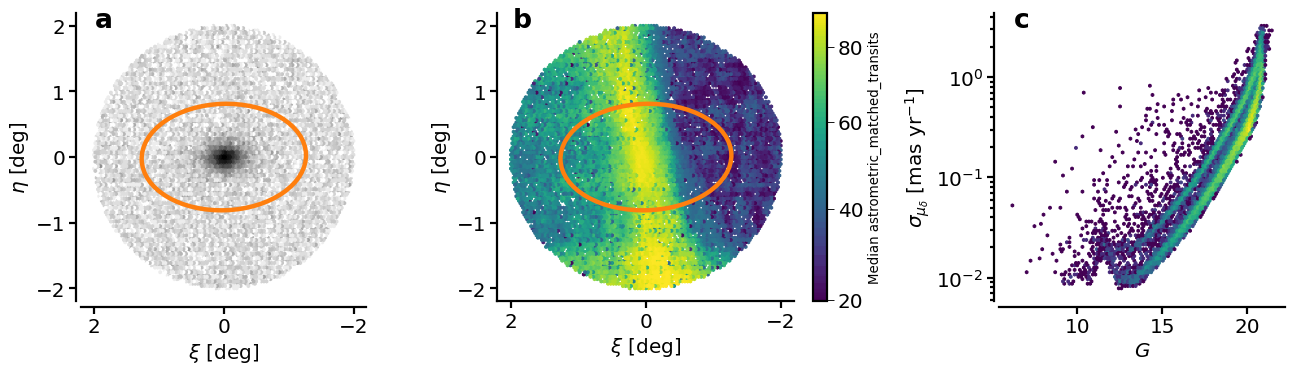

In [7]:
fig = plt.figure(figsize=(16.5,5), tight_layout=True)
gs = GridSpec(1, 3, width_ratios=[5,6.5,5], figure=fig)
axscan = []
for j in [0,1,2]:
    ax = fig.add_subplot(gs[j])
    apply_tufte(ax)
    axscan.append(ax)
    
tidalA = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=4, ec='C1')
tidalB = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=4, ec='C1')
    
axscan[0].hexbin(scl['xi'], scl['eta'], mincnt=1, bins='log', cmap='Greys')
axscan[0].add_patch(tidalA)
axscan[0].set_xlabel(r"$\xi$ [deg]")
axscan[0].set_ylabel(r"$\eta$ [deg]")
axscan[0].invert_xaxis()
axscan[0].text(0.05, 0.95, 'a', transform=axscan[0].transAxes, fontsize=24, weight='bold')

hb = axscan[1].hexbin(scl['xi'], scl['eta'], mincnt=0, C=scl['astrometric_matched_transits'], reduce_C_function=np.median, cmap='viridis')
axscan[1].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = axscan[1].hexbin(scl['xi'], scl['eta'], mincnt=0, C=scl['astrometric_matched_transits'], reduce_C_function=np.median, cmap='viridis', norm=imnorm)
#cax_scan = inset_axes(axscan[1], "5%", "90%", loc='center left', 
#                  bbox_to_anchor=(1.05, 0., 1, 1),
#                  bbox_transform=axscan[1].transAxes,
#                  borderpad=0)
#cbar_scan = fig.colorbar(hb, cax=cax_scan, ticks=[20,40,60,80])
cbar_scan = fig.colorbar(hb, ax=axscan[1], ticks=[20,40,60,80])
cbar_scan.set_label('Median astrometric_matched_transits', fontsize=12)
axscan[1].add_patch(tidalB)
axscan[1].set_xlabel(r"$\xi$ [deg]")
axscan[1].set_ylabel(r"$\eta$ [deg]")
axscan[1].invert_xaxis()
axscan[1].text(0.05, 0.95, 'b', transform=axscan[1].transAxes, fontsize=24, weight='bold')

axscan[2].hexbin(scl['phot_g_mean_mag'], scl['pmdec_error'], mincnt=1, bins='log', yscale='log')
axscan[2].set_xlabel(r"$G$")
axscan[2].set_ylabel(r"$\sigma_{\mu_\delta}$ [mas yr$^{-1}$]")
axscan[2].text(0.05, 0.95, 'c', transform=axscan[2].transAxes, fontsize=24, weight='bold')

plt.savefig('img/sculptor_scanning.pdf')

plt.show()

## Selection of Sculptor galaxy stars on proper motion and parallax

The next code block and plots show the selection on proper motion and parallax, using the full 3D covariance matrix of the proper motions and parallaxes to calculate the distance between a source's data and the Sculptor mean proper motion and distance.

The code below calculates the covariance matrix $\mathbf{C}$ for the parallaxes and proper motions and also the vector

\begin{equation}
    \mathbf{v} = \begin{pmatrix}
        \varpi - \langle\varpi\rangle_\mathrm{scl} \\ \mu_{\alpha*} - \langle\mu_{\alpha*}\rangle_\mathrm{scl} \\ \mu_\delta - \langle\mu_\delta\rangle_\mathrm{scl}
    \end{pmatrix}\,.
\end{equation}

Subsequently the quantity $z = \mathbf{v}^\prime (\mathbf{C}+\mathbf{D})^{-1} \mathbf{v}$ is calculated, where $^\prime$ indicates the transpose and $\mathbf{D}$ is a matix with the squares of the uncertainties of the Sculptor parallax and proper motions on the diagonal:

\begin{equation}
    \mathbf{D} = \begin{pmatrix}
        \sigma_{\langle\varpi\rangle}^2 & 0 & 0 \\
        0 & \sigma_{\langle{\mu_{\alpha*}}\rangle}^2 & 0 \\
        0 & 0 & \sigma_{\langle\mu_\delta\rangle}^2 \\
    \end{pmatrix}
\end{equation}

The quantity $z$ has a $\chi^2$ distribution with three degrees of freedom. Sculptor members can then be selected through upper limits on $z$ which can be chosen to be equivalent to setting a limit of "$\kappa$-$\sigma$" on a 1D normal distribution.

__NOTE A__ After a first iteration of the membership selection it was found that the uncorrected parallaxes of the members have a median of $0.0136$ mas, very close to the Sculptor parallax ($0.3$ magnitudes difference in distance modulus), whereas the corrected parallaxes have a median of $0.0338$ mas ($2.3$ magnitudes different from Sculptor in distance modulus). In addition the median parallax zeropoint for the members is $-0.017$ mas, while the median parallax of the QSO/AGN (from the reference frame list) in this field is $-0.039$ mas. These facts together suggest that it is best to work with the uncorrected parallaxes in this field.

See the remarks on the QSO/AGN parallaxes above.

__NOTE B__ An experiment with selecting on proper motion alone shows that one is left with stars that have too extreme values of $\varpi/\sigma_\varpi$. So the full selection above, including parallax limits is justified.

### Membership selection

Use the method above for a first selection of members. This will be used to refine the Sculptor proper motion and to estimate the unicertainty inflation factors for the proper motions and parallaxes. Note that repeating this step with the inflated uncertainties does not help as due to the larger uncertainties more interlopers are included, leading to larger inflation factors etc. The inflation factors determined are used in the selection of FLAMES members (see below), where the radial velocity is used in addition.

In [8]:
diffvec = np.array([scl['parallax']-plx_scl, scl['pmra']-pmra_scl, scl['pmdec']-pmdec_scl]).T
scl['zscore'] = np.zeros(scl['ra'].size)
dmat = np.zeros((3,3))
dmat[0][0]=plx_scl_unc**2
dmat[1][1]=pmra_scl_unc**2
dmat[2][2]=pmdec_scl_unc**2

for i in range(scl['ra'].size):
    covmat = np.zeros((3,3))
    covmat[0][0] = scl['parallax_error'][i]**2
    covmat[1][1] = scl['pmra_error'][i]**2
    covmat[2][2] = scl['pmdec_error'][i]**2
    covmat[0][1] = scl['parallax_error'][i]*scl['pmra_error'][i]*scl['parallax_pmra_corr'][i]
    covmat[0][2] = scl['parallax_error'][i]*scl['pmdec_error'][i]*scl['parallax_pmdec_corr'][i]
    covmat[1][2] = scl['pmra_error'][i]*scl['pmdec_error'][i]*scl['pmra_pmdec_corr'][i]
    covmat[1][0] = covmat[0][1]
    covmat[2][0] = covmat[0][2]
    covmat[2][1] = covmat[1][2]
    cinv = np.linalg.inv(covmat+dmat)
    scl['zscore'][i] = np.dot(diffvec[i], np.dot(cinv,diffvec[i].T))

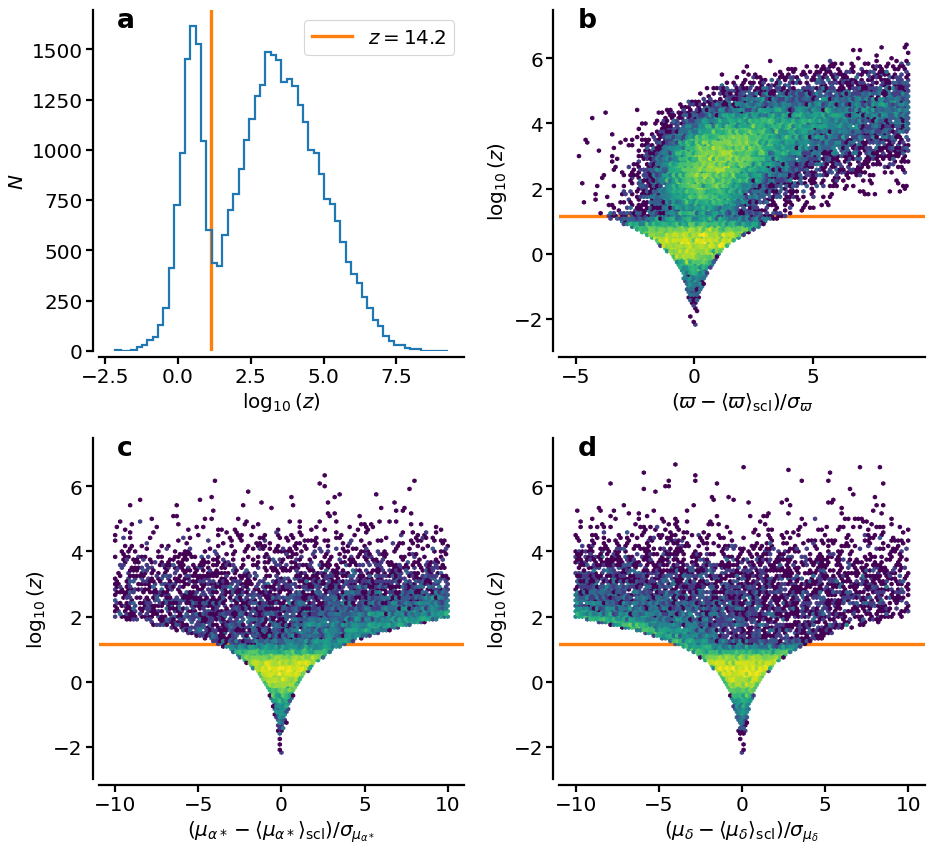

In [9]:
kappa = 3
nu = 3
zscorelim = chi2.ppf(chi2.cdf(kappa**2,1),nu)

fig, axchisq = plt.subplots(2, 2, figsize=(12,11), tight_layout=True)
for ax in axchisq.flatten():
    apply_tufte(ax)

axchisq[0][0].hist(np.log10(scl['zscore']), bins='auto', log=False, histtype='step', lw=2)
axchisq[0][0].axvline(x=np.log10(zscorelim), c='C1', label=rf"$z={zscorelim:.1f}$", zorder=-1)
axchisq[0][0].set_xlabel(rf'$\log_{{10}}(z)$')
axchisq[0][0].set_ylabel(r'$N$')
axchisq[0][0].legend()
axchisq[0][0].text(0.05, 0.95, 'a', transform=axchisq[0][0].transAxes, fontsize=24, weight='bold')

hb = axchisq[0][1].hexbin((scl['parallax']-plx_scl)/scl['parallax_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-5,9,-2.5,7])
axchisq[0][1].set_xlabel(r'$(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$')
axchisq[0][1].set_ylabel(r'$\log_{10}(z)$')
axchisq[0][1].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')
axchisq[0][1].text(0.05, 0.95, 'b', transform=axchisq[0][1].transAxes, fontsize=24, weight='bold')

hb = axchisq[1][0].hexbin((scl['pmra']-pmra_scl)/scl['pmra_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-10,10,-2.5,7])
axchisq[1][0].set_xlabel(r'$(\mu_{\alpha*}-\langle\mu_{\alpha*}\rangle_\mathrm{scl})/\sigma_{\mu_{\alpha*}}$')
axchisq[1][0].set_ylabel(r'$\log_{10}(z)$')
axchisq[1][0].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')
axchisq[1][0].text(0.05, 0.95, 'c', transform=axchisq[1][0].transAxes, fontsize=24, weight='bold')

hb = axchisq[1][1].hexbin((scl['pmdec']-pmdec_scl)/scl['pmdec_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-10,10,-2.5,7])
axchisq[1][1].set_xlabel(r'$(\mu_\delta-\langle\mu_\delta\rangle_\mathrm{scl})/\sigma_{\mu_\delta}$')
axchisq[1][1].set_ylabel(r'$\log_{10}(z)$')
axchisq[1][1].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')
axchisq[1][1].text(0.05, 0.95, 'd', transform=axchisq[1][1].transAxes, fontsize=24, weight='bold')

plt.savefig('img/zscore_and_parallax_over_error.pdf')

plt.show()

The plots above show the distribution of $z$, the distribution of $z$ vs. parallax, and $z$ vs. $(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$. The plots show a clear boundary between the Sculptor members and non-members, especially in the plot of $z$ vs. $(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$. Below the limit of $z=14.2$ (equivalent to $3\sigma$ for a standard 1D normal distribution) the distribution of $(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$ is consistent with a standard normal distribution centered on the parallax of Sculptor. Above this level the distribution strongly deviates from this, indicating that foreground stars in the Milky Way dominate. 

The plot below shows that a simple parallax cut does not work very well as one would lose Sculptor members. Likewise, a cut on $(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$ is not needed thanks to Sculptor standing out fairly well in proper motion space. The presence of interlopers among the selection $z<14.2$ is not excluded.

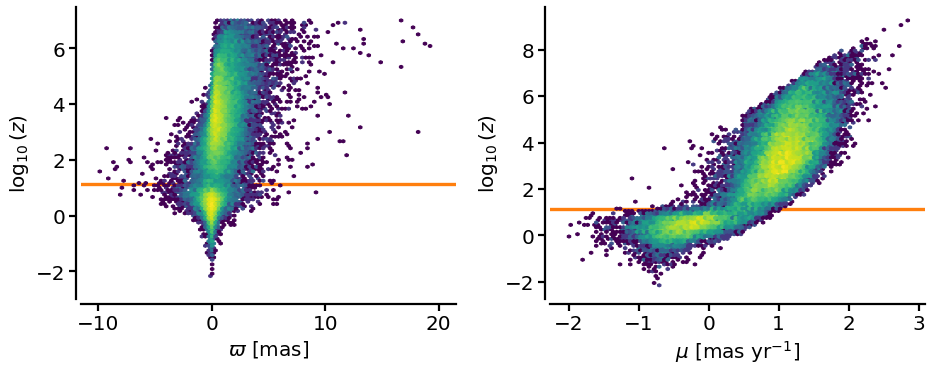

In [10]:
fig, axextra = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
for ax in axextra:
    apply_tufte(ax)

hb = axextra[0].hexbin(scl['parallax'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-10,20,-2.5,7])
axextra[0].set_xlabel(r'$\varpi$ [mas]')
axextra[0].set_ylabel(r'$\log_{10}(z)$')
axextra[0].axhline(y=np.log10(zscorelim), zorder=-1, color='C1')

hb = axextra[1].hexbin(np.log10(scl['pm']), np.log10(scl['zscore']), mincnt=1, bins='log')
axextra[1].set_xlabel(r'$\mu$ [mas yr$^{-1}$]')
axextra[1].set_ylabel(r'$\log_{10}(z)$')
axextra[1].axhline(y=np.log10(zscorelim), zorder=-1, color='C1')

plt.show()

#### Alternative for the above plots

These are intended for the paper.

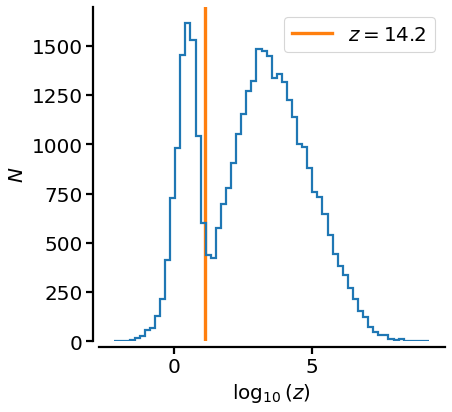

In [11]:
fig, axchisqaltA = plt.subplots(1, 1, figsize=(0.5*12,0.5*11), tight_layout=True)
apply_tufte(axchisqaltA)

axchisqaltA.hist(np.log10(scl['zscore']), bins='auto', log=False, histtype='step', lw=2)
axchisqaltA.axvline(x=np.log10(zscorelim), c='C1', label=rf"$z={zscorelim:.1f}$", zorder=-1)
axchisqaltA.set_xlabel(rf'$\log_{{10}}(z)$')
axchisqaltA.set_ylabel(r'$N$')
axchisqaltA.legend()

plt.savefig('img/zscore_hist.pdf')

plt.show()

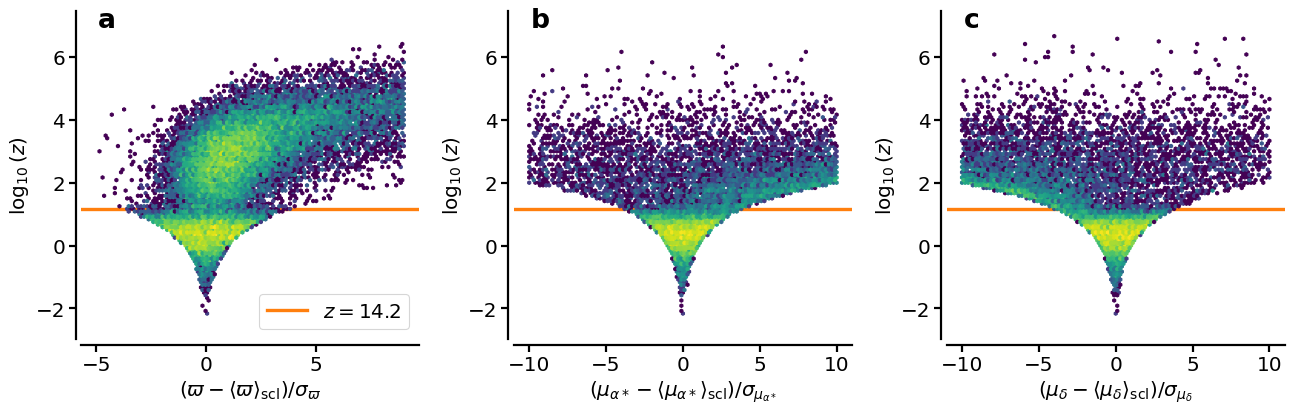

In [12]:
fig, axchisqaltB = plt.subplots(1, 3, figsize=(16.5, 5.5), tight_layout=True)
for ax in axchisqaltB.flatten():
    apply_tufte(ax)

hb = axchisqaltB[0].hexbin((scl['parallax']-plx_scl)/scl['parallax_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-5,9,-2.5,7])
axchisqaltB[0].set_xlabel(r'$(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$')
axchisqaltB[0].set_ylabel(r'$\log_{10}(z)$')
axchisqaltB[0].axhline(y=np.log10(zscorelim), zorder=-1,color='C1', label=rf"$z={zscorelim:.1f}$")
axchisqaltB[0].legend(loc='lower right')
axchisqaltB[0].text(0.05, 0.95, 'a', transform=axchisqaltB[0].transAxes, fontsize=24, weight='bold')

hb = axchisqaltB[1].hexbin((scl['pmra']-pmra_scl)/scl['pmra_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-10,10,-2.5,7])
axchisqaltB[1].set_xlabel(r'$(\mu_{\alpha*}-\langle\mu_{\alpha*}\rangle_\mathrm{scl})/\sigma_{\mu_{\alpha*}}$')
axchisqaltB[1].set_ylabel(r'$\log_{10}(z)$')
axchisqaltB[1].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')
axchisqaltB[1].text(0.05, 0.95, 'b', transform=axchisqaltB[1].transAxes, fontsize=24, weight='bold')

hb = axchisqaltB[2].hexbin((scl['pmdec']-pmdec_scl)/scl['pmdec_error'], np.log10(scl['zscore']), mincnt=1, bins='log', extent=[-10,10,-2.5,7])
axchisqaltB[2].set_xlabel(r'$(\mu_\delta-\langle\mu_\delta\rangle_\mathrm{scl})/\sigma_{\mu_\delta}$')
axchisqaltB[2].set_ylabel(r'$\log_{10}(z)$')
axchisqaltB[2].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')
axchisqaltB[2].text(0.05, 0.95, 'c', transform=axchisqaltB[2].transAxes, fontsize=24, weight='bold')

plt.savefig('img/zscore_plx_and_pm_over_error.pdf')

plt.show()

#### Same selection on control field

In [13]:
diffvec = np.array([scl_control['parallax']-plx_scl, scl_control['pmra']-pmra_scl, scl_control['pmdec']-pmdec_scl]).T
scl_control['zscore'] = np.zeros(scl_control['ra'].size)
dmat = np.zeros((3,3))
dmat[0][0]=plx_scl_unc**2
dmat[1][1]=pmra_scl_unc**2
dmat[2][2]=pmdec_scl_unc**2

for i in range(scl_control['ra'].size):
    covmat = np.zeros((3,3))
    covmat[0][0] = scl_control['parallax_error'][i]**2
    covmat[1][1] = scl_control['pmra_error'][i]**2
    covmat[2][2] = scl_control['pmdec_error'][i]**2
    covmat[0][1] = scl_control['parallax_error'][i]*scl_control['pmra_error'][i]*scl_control['parallax_pmra_corr'][i]
    covmat[0][2] = scl_control['parallax_error'][i]*scl_control['pmdec_error'][i]*scl_control['parallax_pmdec_corr'][i]
    covmat[1][2] = scl_control['pmra_error'][i]*scl_control['pmdec_error'][i]*scl_control['pmra_pmdec_corr'][i]
    covmat[1][0] = covmat[0][1]
    covmat[2][0] = covmat[0][2]
    covmat[2][1] = covmat[1][2]
    cinv = np.linalg.inv(covmat+dmat)
    scl_control['zscore'][i] = np.dot(diffvec[i], np.dot(cinv,diffvec[i].T))

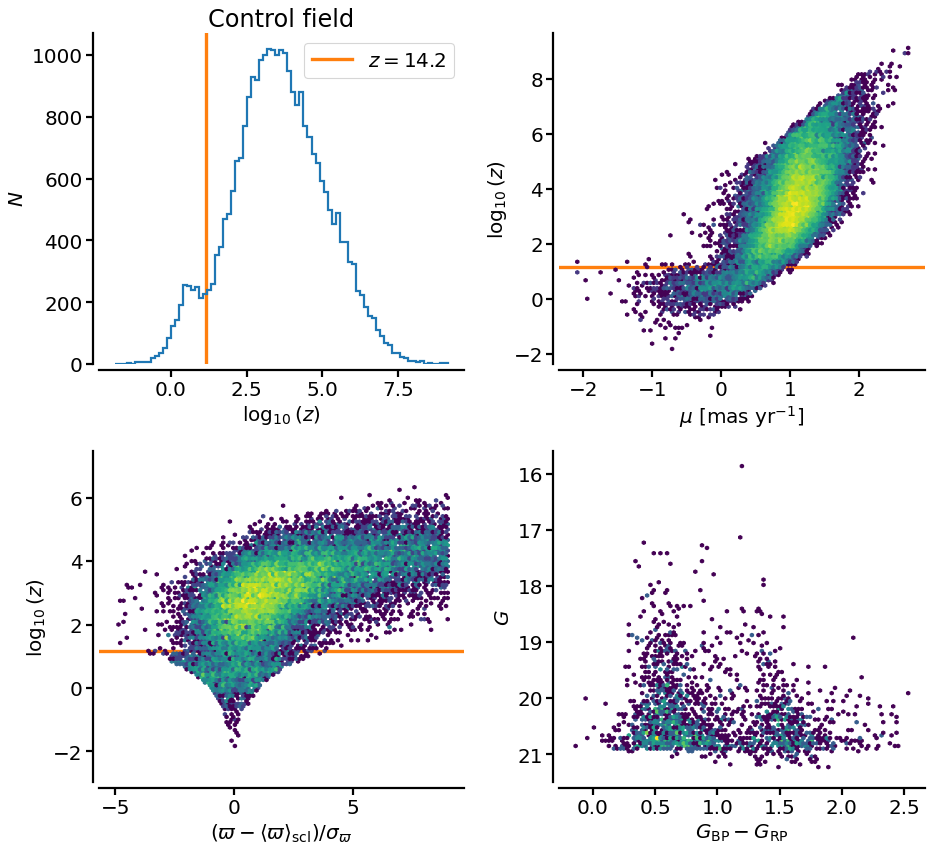

In [14]:
fig, axchisqc = plt.subplots(2, 2, figsize=(12,11), tight_layout=True)
for ax in axchisqc.flatten():
    apply_tufte(ax)

axchisqc[0][0].hist(np.log10(scl_control['zscore']), bins='auto', log=False, histtype='step', lw=2)
axchisqc[0][0].axvline(x=np.log10(zscorelim), c='C1', label=rf"$z={zscorelim:.1f}$", zorder=-1)
axchisqc[0][0].set_xlabel(rf'$\log_{{10}}(z)$')
axchisqc[0][0].set_ylabel(r'$N$')
axchisqc[0][0].set_title("Control field")
axchisqc[0][0].legend()

hb = axchisqc[0][1].hexbin(np.log10(scl_control['pm']), np.log10(scl_control['zscore']), mincnt=1, bins='log')
axchisqc[0][1].set_xlabel(r'$\mu$ [mas yr$^{-1}$]')
axchisqc[0][1].set_ylabel(r'$\log_{10}(z)$')
axchisqc[0][1].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')

hb = axchisqc[1][0].hexbin((scl_control['parallax']-plx_scl)/scl_control['parallax_error'], np.log10(scl_control['zscore']), mincnt=1, bins='log', extent=[-5,9,-2.5,7])
axchisqc[1][0].set_xlabel(r'$(\varpi-\langle\varpi\rangle_\mathrm{scl})/\sigma_\varpi$')
axchisqc[1][0].set_ylabel(r'$\log_{10}(z)$')
axchisqc[1][0].axhline(y=np.log10(zscorelim), zorder=-1,color='C1')

memscontrol = scl_control['zscore']<zscorelim
#hb = axchisqc[1][1].hexbin(scl_control['bp_rp'], scl_control['phot_g_mean_mag'], mincnt=1, bins='log')
hb = axchisqc[1][1].hexbin(scl_control['bp_rp'][memscontrol], scl_control['phot_g_mean_mag'][memscontrol], mincnt=1, bins='log')
axchisqc[1][1].set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$')
axchisqc[1][1].set_ylabel(r'$G$')
axchisqc[1][1].invert_yaxis()

plt.show()

#### Continue with Sculptor

Median and RSE of normalized parallax: 0.00880, 1.07
Median and RSE of normalized pmra: 0.03081, 1.12
Median and RSE of normalized pmdec: 0.02922, 1.14

Median parallax: 0.0136 mas
Median pmra: 0.1049 mas/yr
Median pmdec: -0.1507 mas/yr
Weighted mean (pmra, pmdec): (0.095, -0.154) mas/yr
Covariance matrix mean proper motion: [[ 5.23886759e-06 -1.43315036e-06]
 [-1.43315036e-06  2.94515725e-06]]
Uncertainties and correlation coefficient of the mean proper motions: 0.002, 0.002, -0.36


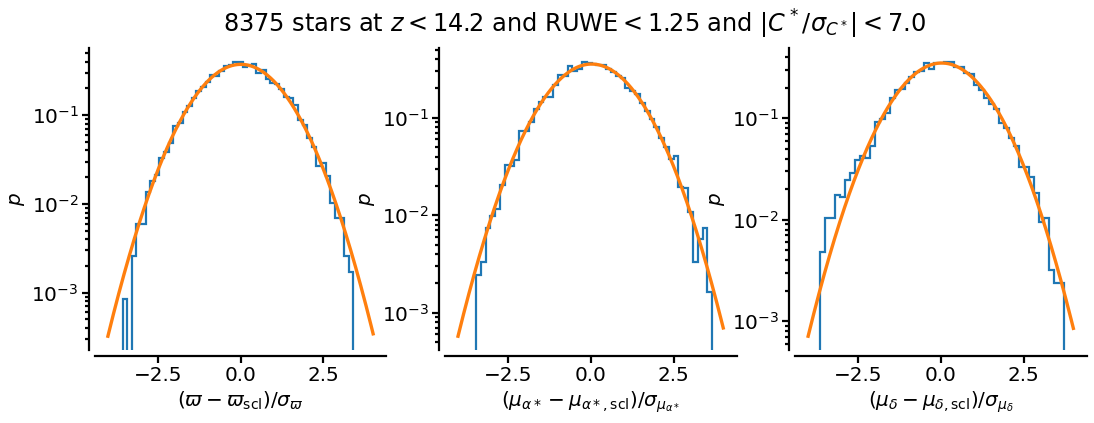

In [15]:
fig, axph = plt.subplots(1, 3, figsize=(16,5))
for ax in axph:
    apply_tufte(ax)

ruwelim = 1.25
cstarlim = 7
mems = (scl['zscore']<zscorelim) & (scl['ruwe']<ruwelim) & (scl['cstar_norm']<cstarlim)
memsbad = (scl['zscore']<zscorelim) & (scl['ruwe']>=ruwelim) & (scl['cstar_norm']>=cstarlim)
plx_normalized = ((scl['parallax']-plx_scl)/scl['parallax_error'])[mems]
pmra_normalized = ((scl['pmra']-pmra_scl)/scl['pmra_error'])[mems]
pmdec_normalized = ((scl['pmdec']-pmdec_scl)/scl['pmdec_error'])[mems]

nmem = plx_normalized.size
med_nplx = np.median(plx_normalized)
rse_nplx = rse(plx_normalized)
med_npmra = np.median(pmra_normalized)
rse_npmra = rse(pmra_normalized)
med_npmdec = np.median(pmdec_normalized)
rse_npmdec = rse(pmdec_normalized)

med_plx = np.median(scl['parallax'][scl['zscore']<zscorelim])
med_pmra = np.median(scl['pmra'][scl['zscore']<zscorelim])
med_pmdec = np.median(scl['pmdec'][scl['zscore']<zscorelim])

print(f"Median and RSE of normalized parallax: {med_nplx:.5f}, {rse_nplx:.2f}")
print(f"Median and RSE of normalized pmra: {med_npmra:.5f}, {rse_npmra:.2f}")
print(f"Median and RSE of normalized pmdec: {med_npmdec:.5f}, {rse_npmdec:.2f}")
print()
print(f"Median parallax: {med_plx:.4f} mas")
print(f"Median pmra: {med_pmra:.4f} mas/yr")
print(f"Median pmdec: {med_pmdec:.4f} mas/yr")

pmra_scl_new, pmdec_scl_new, covpm_scl_new = weighted_mean_twod(scl['pmra'][mems], scl['pmdec'][mems], scl['pmra_error'][mems], scl['pmdec_error'][mems], scl['pmra_pmdec_corr'][mems])
print(f"Weighted mean (pmra, pmdec): ({pmra_scl_new:.3f}, {pmdec_scl_new:.3f}) mas/yr")
print(f"Covariance matrix mean proper motion: {covpm_scl_new}")
pmra_scl_new_unc = np.sqrt(covpm_scl_new[0][0])
pmdec_scl_new_unc = np.sqrt(covpm_scl_new[1][1])
pmra_pmdec_corr_scl_new = covpm_scl_new[1][0]/(pmra_scl_new_unc*pmdec_scl_new_unc)
print(f"Uncertainties and correlation coefficient of the mean proper motions: {pmra_scl_new_unc:.3f}, {pmdec_scl_new_unc:.3f}, {pmra_pmdec_corr_scl_new:.2f}")

axph[0].hist(plx_normalized, bins='auto', histtype='step', density=True, log=True, lw=2)
zz = np.linspace(-4,4,1000)
axph[0].plot(zz, norm.pdf(zz, loc=med_nplx, scale=rse_nplx))
axph[0].set_xlabel(r'$(\varpi-\varpi_\mathrm{scl})/\sigma_\varpi$')
axph[0].set_ylabel(r'$p$')

axph[1].hist(pmra_normalized, bins='auto', histtype='step', density=True, log=True, lw=2)
axph[1].plot(zz, norm.pdf(zz, loc=med_npmra, scale=rse_npmra))
axph[1].set_xlabel(r'$(\mu_{\alpha*}-\mu_{\alpha*,\mathrm{scl}})/\sigma_{\mu_{\alpha*}}$')
axph[1].set_ylabel(r'$p$')

axph[2].hist(pmdec_normalized, bins='auto', histtype='step', density=True, log=True, lw=2)
axph[2].plot(zz, norm.pdf(zz, loc=med_npmdec, scale=rse_npmdec))
axph[2].set_xlabel(r'$(\mu_\delta-\mu_{\delta,\mathrm{scl}})/\sigma_{\mu_\delta}$')
axph[2].set_ylabel(r'$p$')

fig.suptitle(rf"{nmem} stars at $z<{zscorelim:.1f}$ and $\mathrm{{RUWE}}<{ruwelim:.2f}$ and $|C^*/\sigma_{{C^*}}|<{cstarlim:.1f}$")

plt.show()

#### Further examination of the selected Sculptor stars

The plots below are intended to find out if interlopers can be removed with some additional selection on data quality indicators. The bottom line is that a selection on $|C^*/\sigma_{C^*}|<2$ and $\mathrm{RUWE}<1.25$ removes what are probably galaxies or other problematic sources, but this does not remove the interloper population of foreground stars. The latter lead to the slight skewing of the $\mu_\delta$ distribution to negative values. This is also hinted at in the proper motion plot colour coded by parallax.

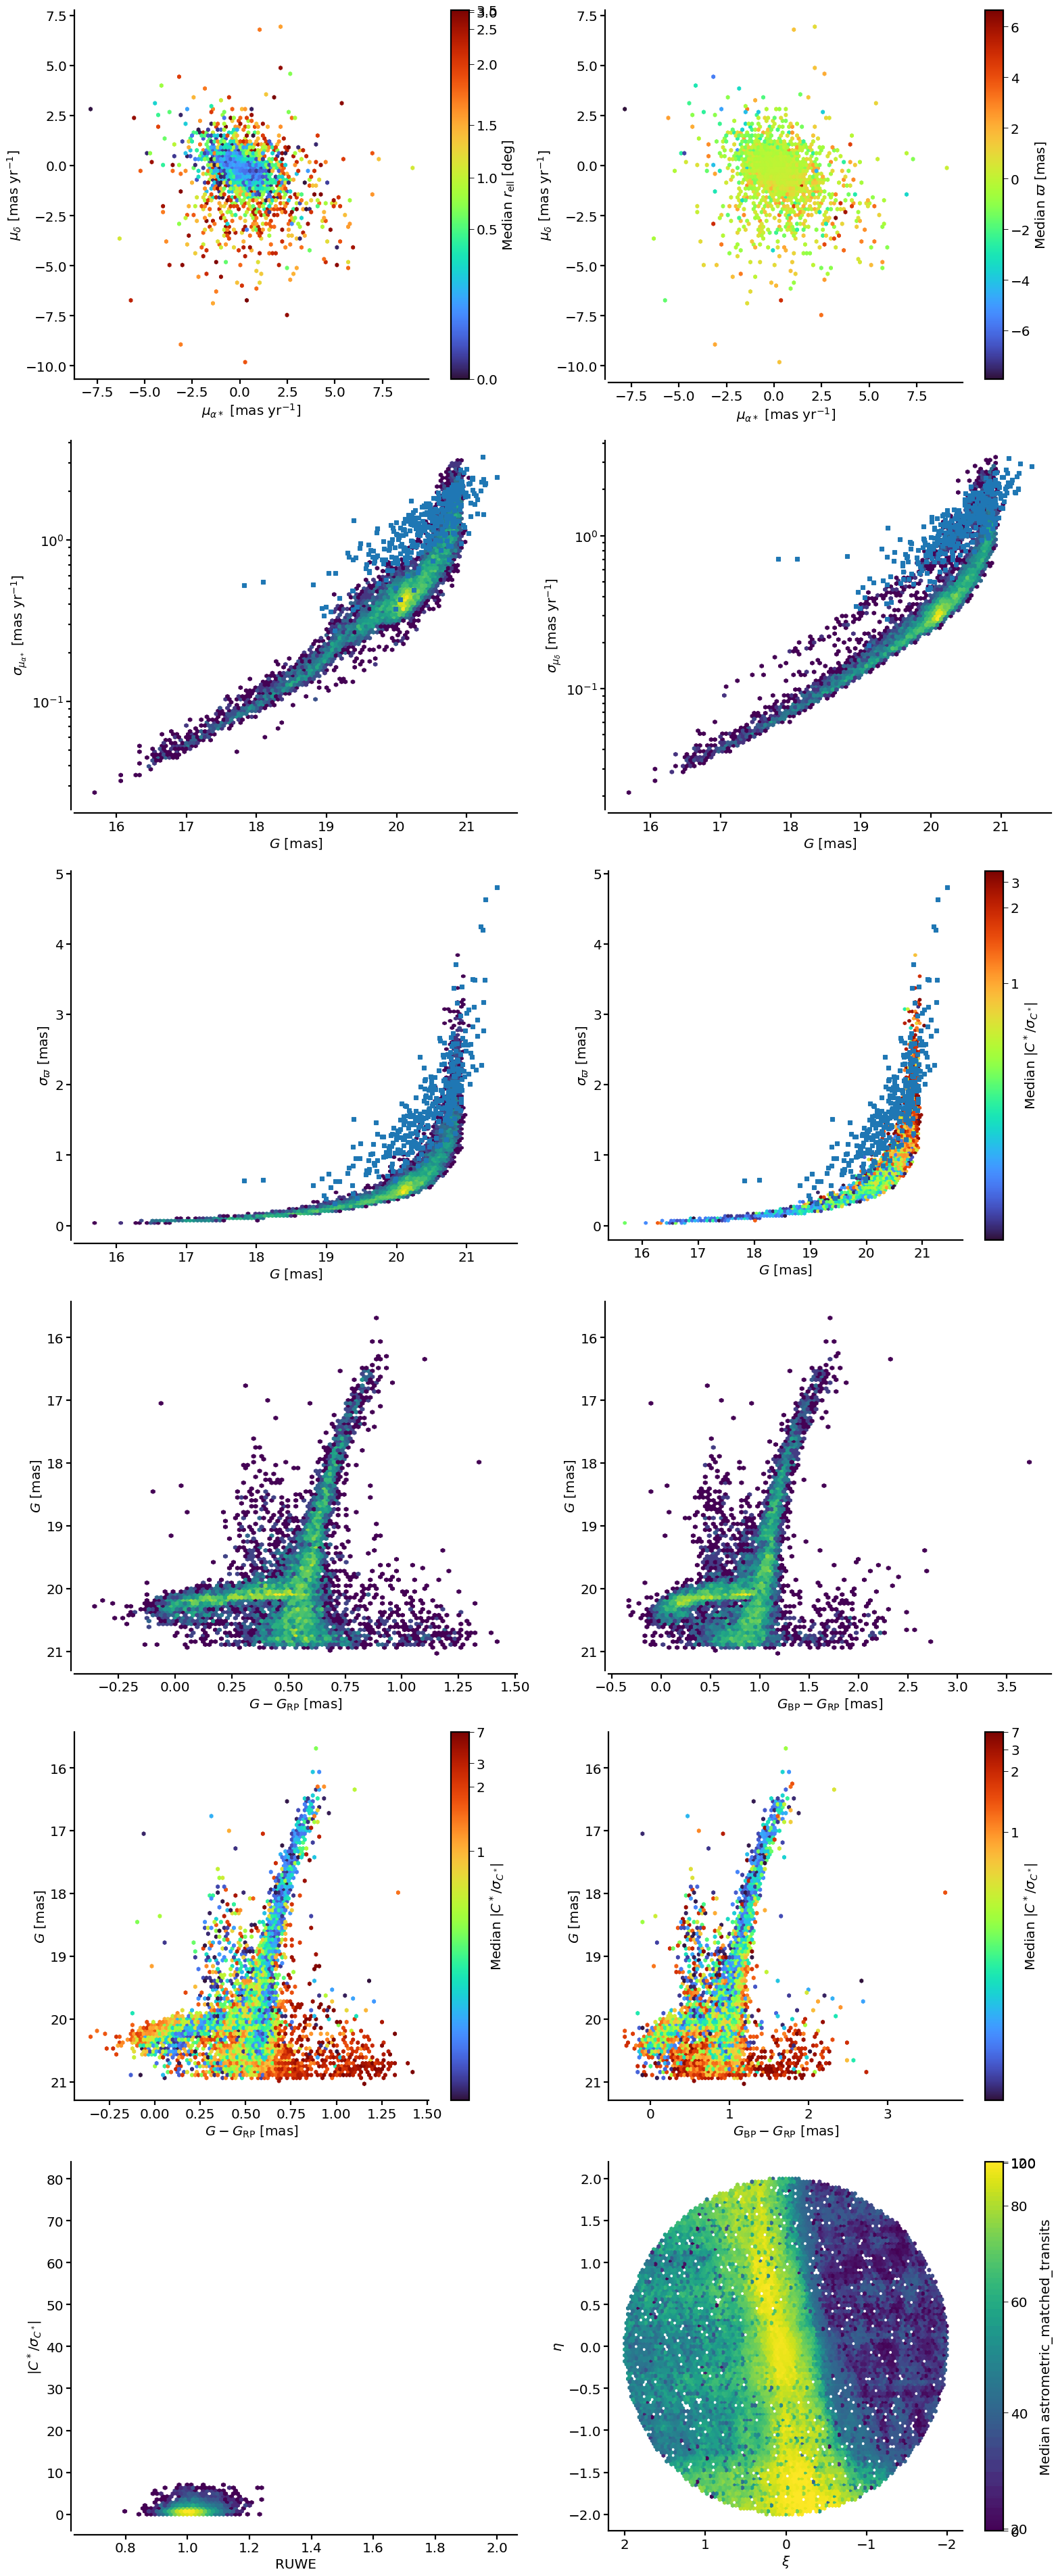

In [16]:
fig, myax = plt.subplots(6, 2, figsize=(20,6*8), tight_layout=True)
for ax in myax.flatten():
    apply_tufte(ax)

hb = myax[0][0].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, C=scl['ellradius'][mems], reduce_C_function=np.median, cmap='turbo')
myax[0][0].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = myax[0][0].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, C=scl['ellradius'][mems], reduce_C_function=np.median, cmap='turbo', norm=imnorm)
cbar = fig.colorbar(hb, ax=myax[0][0])#, ticks=[1,3,8])
cbar.set_label(r'Median $r_\mathrm{ell}$ [deg]')
myax[0][0].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
myax[0][0].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

hb = myax[0][1].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, C=scl['parallax'][mems], reduce_C_function=np.median, cmap='turbo')
cbar = fig.colorbar(hb, ax=myax[0][1])#, ticks=[-0.5, 0, 0.5])
cbar.set_label(r'Median $\varpi$ [mas]')
myax[0][1].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
myax[0][1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

hb = myax[1][0].hexbin(scl['phot_g_mean_mag'][mems], scl['pmra_error'][mems], mincnt=1, bins='log', yscale='log')
myax[1][0].semilogy(scl['phot_g_mean_mag'][memsbad], scl['pmra_error'][memsbad], 's')
myax[1][0].set_xlabel(r'$G$ [mas]')
myax[1][0].set_ylabel(r'$\sigma_{\mu_{\alpha*}}$ [mas yr$^{-1}$]')

hb = myax[1][1].hexbin(scl['phot_g_mean_mag'][mems], scl['pmdec_error'][mems], mincnt=1, bins='log', yscale='log')
myax[1][1].semilogy(scl['phot_g_mean_mag'][memsbad], scl['pmdec_error'][memsbad], 's')
myax[1][1].set_xlabel(r'$G$ [mas]')
myax[1][1].set_ylabel(r'$\sigma_{\mu_\delta}$ [mas yr$^{-1}$]')

hb = myax[2][0].hexbin(scl['phot_g_mean_mag'][mems], scl['parallax_error'][mems], mincnt=1, bins='log')
myax[2][0].plot(scl['phot_g_mean_mag'][memsbad], scl['parallax_error'][memsbad], 's')
myax[2][0].set_xlabel(r'$G$ [mas]')
myax[2][0].set_ylabel(r'$\sigma_\varpi$ [mas]')

hb = myax[2][1].hexbin(scl['phot_g_mean_mag'][mems], scl['parallax_error'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo')
myax[2][1].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = myax[2][1].hexbin(scl['phot_g_mean_mag'][mems], scl['parallax_error'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo', norm=imnorm)
cbar = fig.colorbar(hb, ax=myax[2][1], ticks=[1,2,3])
cbar.set_label(r'Median $|C^*/\sigma_{C^*}|$')
myax[2][1].plot(scl['phot_g_mean_mag'][memsbad], scl['parallax_error'][memsbad], 's')
myax[2][1].set_xlabel(r'$G$ [mas]')
myax[2][1].set_ylabel(r'$\sigma_\varpi$ [mas]')

hb = myax[3][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=1, bins='log')
myax[3][0].set_xlabel(r'$G-G_\mathrm{RP}$ [mas]')
myax[3][0].set_ylabel(r'$G$ [mas]')
myax[3][0].invert_yaxis()

hb = myax[3][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=1, bins='log')
myax[3][1].set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$ [mas]')
myax[3][1].set_ylabel(r'$G$ [mas]')
myax[3][1].invert_yaxis()

hb = myax[4][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo')
myax[4][0].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = myax[4][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo', norm=imnorm)
cbar = fig.colorbar(hb, ax=myax[4][0], ticks=[1,2,3,7])
cbar.set_label(r'Median $|C^*/\sigma_{C^*}|$')
myax[4][0].set_xlabel(r'$G-G_\mathrm{RP}$ [mas]')
myax[4][0].set_ylabel(r'$G$ [mas]')
myax[4][0].invert_yaxis()

hb = myax[4][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo')
myax[4][1].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = myax[4][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['cstar_norm'][mems], reduce_C_function=np.median, cmap='turbo', norm=imnorm)
cbar = fig.colorbar(hb, ax=myax[4][1], ticks=[1,2,3,7])
cbar.set_label(r'Median $|C^*/\sigma_{C^*}|$')
myax[4][1].set_xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$ [mas]')
myax[4][1].set_ylabel(r'$G$ [mas]')
myax[4][1].invert_yaxis()

hb = myax[5][0].hexbin(scl['ruwe'][mems], scl['cstar_norm'][mems], mincnt=1, bins='log', extent=[0.7,2,0,80])
myax[5][0].set_xlabel('RUWE')
myax[5][0].set_ylabel(r'$|C^*/\sigma_{C^*}|$')

hb = myax[5][1].hexbin(scl['xi'], scl['eta'], mincnt=0, C=scl['astrometric_matched_transits'], reduce_C_function=np.median)
myax[5][1].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = myax[5][1].hexbin(scl['xi'], scl['eta'], mincnt=0, C=scl['astrometric_matched_transits'], reduce_C_function=np.median, norm=imnorm)
cbar = fig.colorbar(hb, ax=myax[5][1])#, ticks=[1,2,3,7])
cbar.set_label('Median astrometric_matched_transits')
myax[5][1].set_xlabel(r'$\xi$')
myax[5][1].set_ylabel(r'$\eta$')
myax[5][1].invert_xaxis()

plt.show()

### Plot for the paper
Shows the properties of the proper motion and parallax seected members.

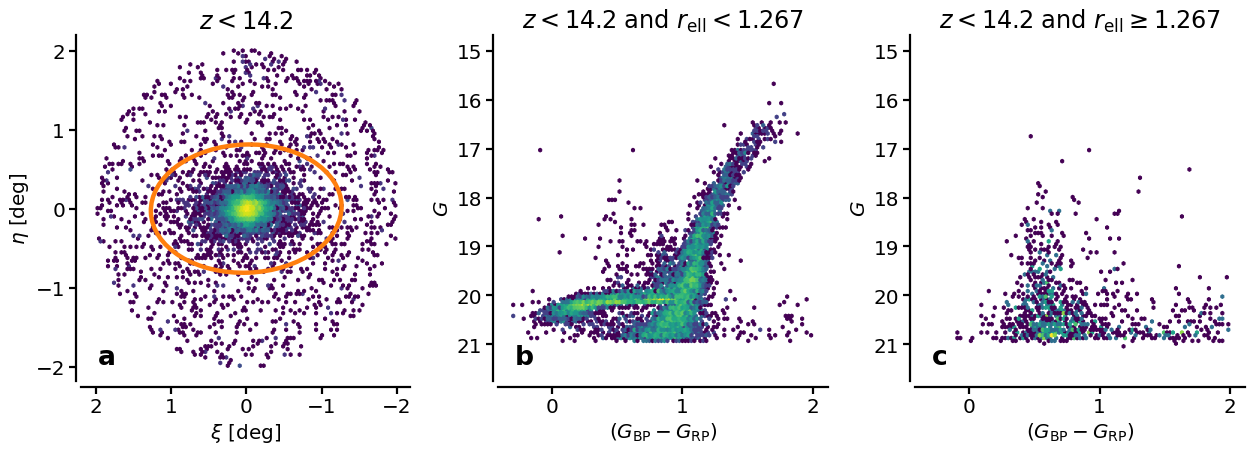

In [17]:
fig, axeta = plt.subplots(1, 3, figsize=(16,6), tight_layout=True)
for ax in axeta:
    apply_tufte(ax)
    
tidal = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=4, ec='C1')
skysel = scl['ellradius']<rellmax
extnt = [-0.3, 2, 15.0, scl['phot_g_mean_mag'].max()]

hb = axeta[0].hexbin(scl['xi'][mems], scl['eta'][mems], mincnt=0, bins='log')
axeta[0].add_patch(tidal)
axeta[0].set_xlabel(r'$\xi$ [deg]')
axeta[0].set_ylabel(r'$\eta$ [deg]')
axeta[0].set_title(rf'$z<{zscorelim:.1f}$')
axeta[0].invert_xaxis()
axeta[0].text(0.05, 0.05, 'a', transform=axeta[0].transAxes, fontsize=24, weight='bold')

hb = axeta[1].hexbin(scl['bp_rp'][mems & skysel], scl['phot_g_mean_mag'][mems & skysel], mincnt=0, bins='log', extent=extnt)
#axeta[1].plot(scl['g_rp'][mems & np.logical_not(skysel)], scl['phot_g_mean_mag'][mems & np.logical_not(skysel)], '+', c='C1')
axeta[1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axeta[1].set_ylabel(r'$G$')
axeta[1].invert_yaxis()
axeta[1].set_title(rf'$z<{zscorelim:.1f}$ and $r_\mathrm{{ell}}<{rellmax:.3f}$')
axeta[1].text(0.05, 0.05, 'b', transform=axeta[1].transAxes, fontsize=24, weight='bold')

hb = axeta[2].hexbin(scl['bp_rp'][mems & np.logical_not(skysel)], scl['phot_g_mean_mag'][mems & np.logical_not(skysel)], mincnt=0, bins='log', extent=extnt)
#axeta[2].plot(scl['bp_rp'][mems & np.logical_not(skysel)], scl['phot_g_mean_mag'][mems & np.logical_not(skysel)], '+', c='C1')
axeta[2].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axeta[2].set_ylabel(r'$G$')
axeta[2].invert_yaxis()
axeta[2].set_title(rf'$z<{zscorelim:.1f}$ and $r_\mathrm{{ell}}\geq{rellmax:.3f}$')
axeta[2].text(0.05, 0.05, 'c', transform=axeta[2].transAxes, fontsize=24, weight='bold')

plt.savefig('img/sculptor_3dmem_properties.pdf')

plt.show()

## Selection on proper motion, parallax, and radial velocity

### Calculate the membership metric including the radial velocity

The calculations below are the same as for the parallax/proper motion membership above, expect that now a 4D vector of observables is considered:

\begin{equation}
    \mathbf{v} = \begin{pmatrix}
        \varpi - \langle\varpi\rangle \\ \mu_{\alpha*} - \langle\mu_{\alpha*}\rangle \\ \mu_\delta - \langle\mu_\delta\rangle \\
        v_\mathrm{rad} - \langle v_\mathrm{rad}\rangle
    \end{pmatrix}\,.
\end{equation}

The matrix $\mathbf{D}$ becomes:

\begin{equation}
    \begin{pmatrix}
        \sigma_\varpi^2 & 0 & 0 \\
        0 & \mathbf{C}_{\mu,\mathrm{scl}} & 0 \\
        0 & 0 & \sigma_{v_\mathrm{rad, scl}}^2 + \sigma_\mathrm{scl}^2
    \end{pmatrix}\,,
\end{equation}

The value of $\langle v_\mathrm{rad}\rangle$, $110.6\pm0.5$ km s$^{-1}$, and the velocity dispersion, $\sigma_\mathrm{scl}=10.10\pm0.30$ km s$^{-1}$, are as listed in [Battaglia et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A..54B/abstract). $\mathbf{C}_\mu$ is the covariance matrix of the mean Scupltor proper motions calculated after the first membership selection step above.

__NOTE__ In the membership selection step below, focused on the FLAMES sample, the parallax and proper motion uncertainties are inflated by the factors derived in the Sculptor parallax-proper motion member selection above.

In [18]:
vrad_scl = 110.6
vrad_scl_unc = 0.5
vdisp_scl = 10.10

diffvec = np.array([scl_flames['parallax']-plx_scl, scl_flames['pmra']-pmra_scl_new, scl_flames['pmdec']-pmdec_scl_new, scl_flames['rv_flames']-vrad_scl]).T
scl_flames['zscore'] = np.zeros(scl_flames['ra'].size)
dmat = np.zeros((4,4))
dmat[0][0] = plx_scl_unc**2
dmat[1:3,1:3] = covpm_scl_new
dmat[3][3] = vrad_scl_unc**2 + vdisp_scl**2

for i in range(scl_flames['ra'].size):
    covmat = np.zeros((4,4))
    covmat[0][0] = scl_flames['parallax_error'][i]**2*rse_nplx**2
    covmat[1][1] = scl_flames['pmra_error'][i]**2*rse_npmra**2
    covmat[2][2] = scl_flames['pmdec_error'][i]**2*rse_npmdec**2
    covmat[0][1] = scl_flames['parallax_error'][i]*scl_flames['pmra_error'][i]*scl_flames['parallax_pmra_corr'][i]*rse_nplx*rse_npmra
    covmat[0][2] = scl_flames['parallax_error'][i]*scl_flames['pmdec_error'][i]*scl_flames['parallax_pmdec_corr'][i]*rse_nplx*rse_npmdec
    covmat[1][2] = scl_flames['pmra_error'][i]*scl_flames['pmdec_error'][i]*scl_flames['pmra_pmdec_corr'][i]*rse_npmra*rse_npmdec
    covmat[1][0] = covmat[0][1]
    covmat[2][0] = covmat[0][2]
    covmat[2][1] = covmat[1][2]
    covmat[3][3] = scl_flames['rv_flames_unc'][i]**2
    cinv = np.linalg.inv(covmat+dmat)
    scl_flames['zscore'][i] = np.dot(diffvec[i], np.dot(cinv,diffvec[i].T))

#### Membership metric distribution

Compare the metric distributions for the 'members' and 'non-members'. The $\kappa=3$ limit is shown for the $\chi^2_4$ distribution.

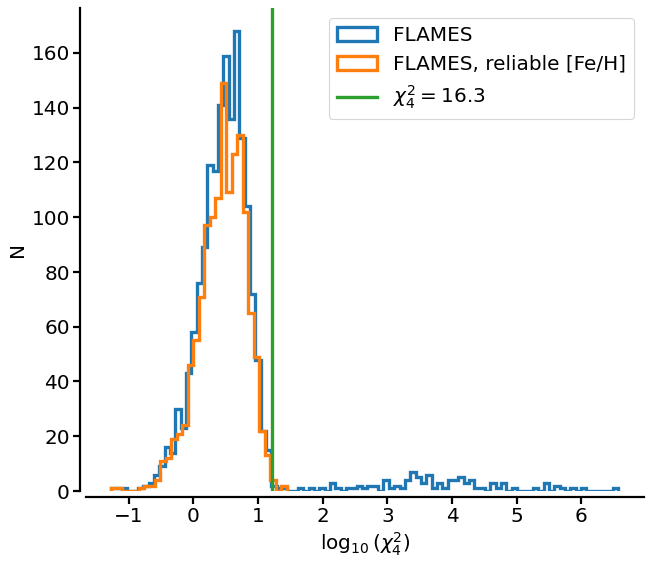

In [19]:
kappa = 3
nu = 4
zscorelim_fl = chi2.ppf(chi2.cdf(kappa**2,1),nu)

fig, axflames = plt.subplots(1, 1, figsize=(9,8))
apply_tufte(axflames)
axflames.hist(np.log10(scl_flames["zscore"]),  bins="auto", histtype="step", lw=3, label="FLAMES")
axflames.hist(np.log10(scl_flames["zscore"][scl_flames['reliable_feh']==0]),  bins="auto", histtype="step", lw=3, label="FLAMES, reliable [Fe/H]")
axflames.axvline(x=np.log10(zscorelim_fl), c='C2', label=rf"$\chi^2_{nu}={zscorelim_fl:.1f}$")
axflames.set_xlabel(rf"$\log_{{10}}(\chi^2_{nu})$")
axflames.set_ylabel("N")
axflames.legend()

plt.show()

34.555046564970844
Number of members: 1604


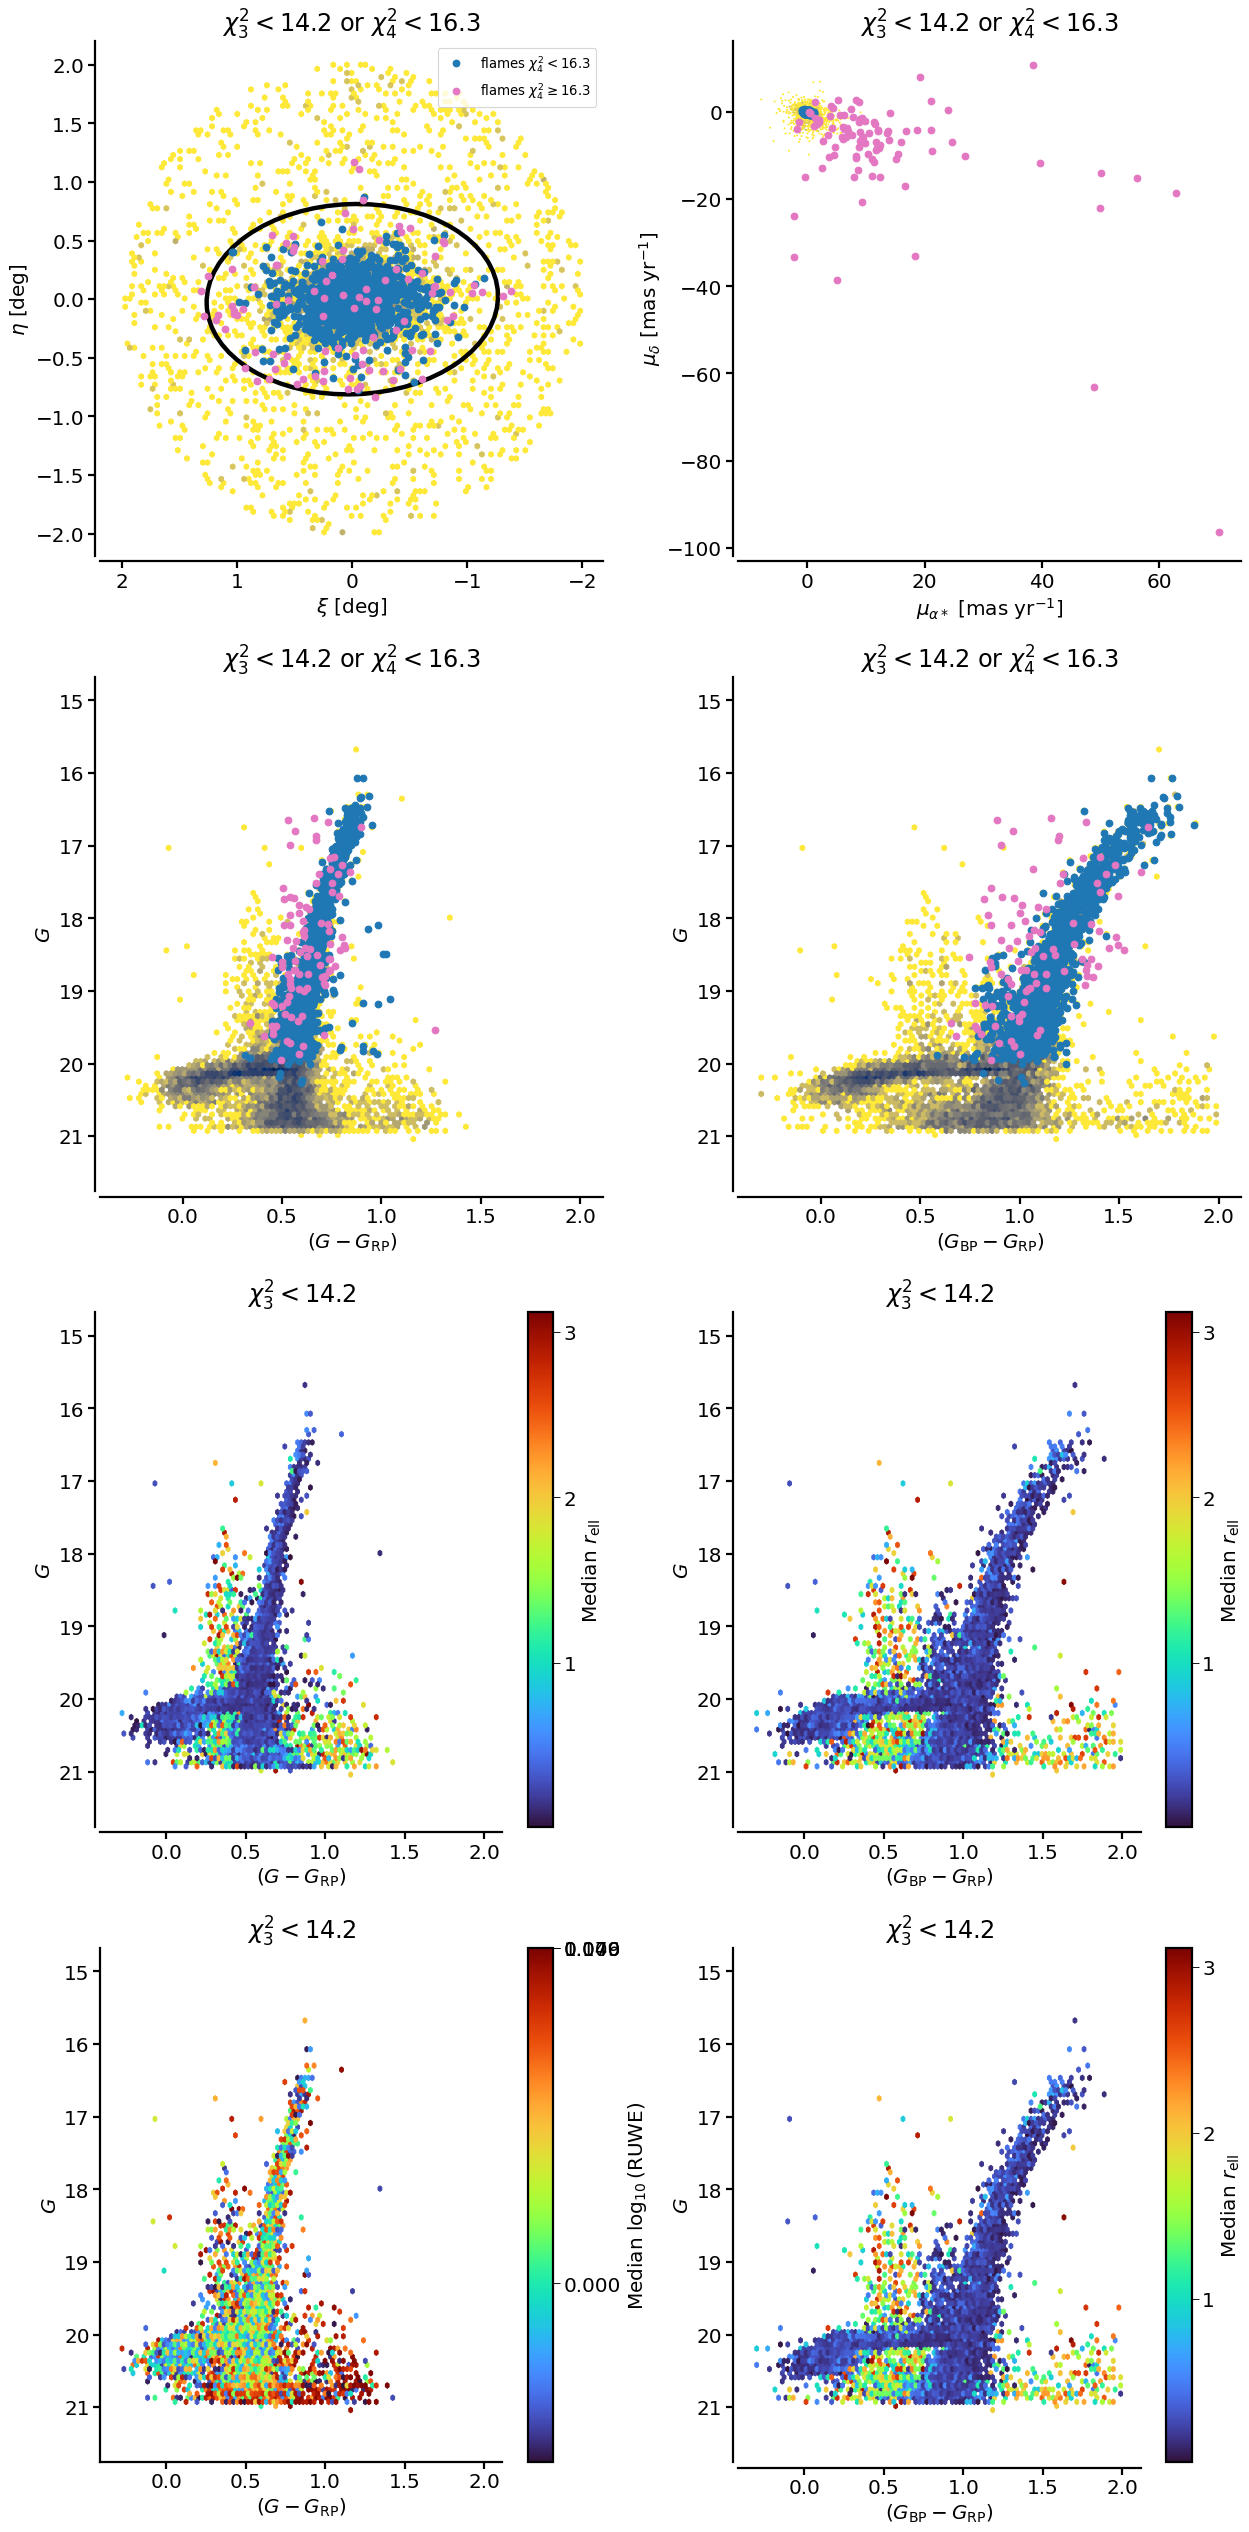

In [20]:
fig = plt.figure(figsize=(16,32), tight_layout=True)
gs = GridSpec(4, 2, figure=fig)
axfl = []
for i in range(4):
    axfl.append([])
    for j in range(2):
        ax = fig.add_subplot(gs[i,j])
        apply_tufte(ax)
        axfl[i].append(ax)
        
flmems = scl_flames['zscore']<zscorelim_fl
flnonmems = np.logical_not(flmems)
zlim_flames_fivesigma = chi2.ppf(chi2.cdf(5**2,1),4)
print(zlim_flames_fivesigma)
flnonmems_borderline = flnonmems & (scl_flames['pm']<1.0) #& (scl_flames['zscore']<zlim_flames_fivesigma)
borderline = Table()
borderline['source_id'] = scl_flames['source_id'][flnonmems_borderline]
borderline.write('bordeline_W2.txt', format='ascii', overwrite=True)

print(f"Number of members: {scl_flames['ra'][flmems].size}")
tidalB = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=4, ec='k')
        
hb = axfl[0][0].hexbin(scl['xi'][mems], scl['eta'][mems], mincnt=0, bins='log', cmap='cividis_r')
axfl[0][0].plot(scl_flames['xi'][flmems], scl_flames['eta'][flmems], 'o', label=rf"flames $\chi^2_{{4}}<{zscorelim_fl:.1f}$")
axfl[0][0].plot(scl_flames['xi'][flnonmems], scl_flames['eta'][flnonmems], 'o', color='C6', label=rf"flames $\chi^2_{{4}}\geq{zscorelim_fl:.1f}$")
axfl[0][0].add_patch(tidalB)
axfl[0][0].set_xlabel(r'$\xi$ [deg]')
axfl[0][0].set_ylabel(r'$\eta$ [deg]')
axfl[0][0].set_title(rf'$\chi^2_3<{zscorelim:.1f}$ or $\chi^2_4<{zscorelim_fl:.1f}$')
axfl[0][0].invert_xaxis()
axfl[0][0].legend(fontsize=12)

hb = axfl[0][1].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, bins='log', cmap="cividis_r")
axfl[0][1].plot(scl_flames['pmra'][flmems], scl_flames['pmdec'][flmems], 'o')
axfl[0][1].plot(scl_flames['pmra'][flnonmems], scl_flames['pmdec'][flnonmems], 'o', color='C6')
axfl[0][1].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
axfl[0][1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')
axfl[0][1].set_title(rf'$\chi^2_3<{zscorelim:.1f}$ or $\chi^2_4<{zscorelim_fl:.1f}$')

hb = axfl[1][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="cividis_r")
axfl[1][0].plot(scl_flames['g_rp'][flmems], scl_flames['phot_g_mean_mag'][flmems], 'o')
axfl[1][0].plot(scl_flames['g_rp'][flnonmems], scl_flames['phot_g_mean_mag'][flnonmems], 'o', color='C6')
axfl[1][0].set_xlabel(r'$(G-G_\mathrm{RP})$')
axfl[1][0].set_ylabel(r'$G$')
axfl[1][0].invert_yaxis()
axfl[1][0].set_title(rf'$\chi^2_3<{zscorelim:.1f}$ or $\chi^2_4<{zscorelim_fl:.1f}$')

hb = axfl[1][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="cividis_r")
axfl[1][1].plot(scl_flames['bp_rp'][flmems], scl_flames['phot_g_mean_mag'][flmems], 'o')
axfl[1][1].plot(scl_flames['bp_rp'][flnonmems], scl_flames['phot_g_mean_mag'][flnonmems], 'o', color='C6')
axfl[1][1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axfl[1][1].set_ylabel(r'$G$')
axfl[1][1].invert_yaxis()
axfl[1][1].set_title(rf'$\chi^2_3<{zscorelim:.1f}$ or $\chi^2_4<{zscorelim_fl:.1f}$')

hb = axfl[2][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['ellradius'][mems], reduce_C_function=np.median, extent=extnt, cmap="turbo")
cbar = fig.colorbar(hb, ax=axfl[2][0], ticks=[0,1,2,3])
cbar.set_label(r'Median $r_\mathrm{ell}$')
axfl[2][0].set_xlabel(r'$(G-G_\mathrm{RP})$')
axfl[2][0].set_ylabel(r'$G$')
axfl[2][0].invert_yaxis()
axfl[2][0].set_title(rf'$\chi^2_3<{zscorelim:.1f}$')

hb = axfl[2][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['ellradius'][mems], reduce_C_function=np.median, extent=extnt, cmap="turbo")
cbar = fig.colorbar(hb, ax=axfl[2][1], ticks=[0,1,2,3])
cbar.set_label(r'Median $r_\mathrm{ell}$')
axfl[2][1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axfl[2][1].set_ylabel(r'$G$')
axfl[2][1].invert_yaxis()
axfl[2][1].set_title(rf'$\chi^2_3<{zscorelim:.1f}$')

hb = axfl[3][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=np.log10(scl['ruwe'][mems]), reduce_C_function=np.median, extent=extnt, cmap="turbo")
axfl[3][0].clear()
imnorm = ImageNormalize(hb.get_array(), stretch=HistEqStretch(hb.get_array()))
hb = axfl[3][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=np.log10(scl['ruwe'][mems]), reduce_C_function=np.median, extent=extnt, norm=imnorm, cmap="turbo")
cbar = fig.colorbar(hb, ax=axfl[3][0], ticks=[0,np.log10(1.2),np.log10(1.4),1])
cbar.set_label(r'Median $\log_{10}(\mathrm{RUWE})$')
axfl[3][0].set_xlabel(r'$(G-G_\mathrm{RP})$')
axfl[3][0].set_ylabel(r'$G$')
axfl[3][0].invert_yaxis()
axfl[3][0].set_title(rf'$\chi^2_3<{zscorelim:.1f}$')

hb = axfl[3][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, C=scl['ellradius'][mems], reduce_C_function=np.median, extent=extnt, cmap="turbo")
cbar = fig.colorbar(hb, ax=axfl[3][1], ticks=[0,1,2,3])
cbar.set_label(r'Median $r_\mathrm{ell}$')
axfl[3][1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axfl[3][1].set_ylabel(r'$G$')
axfl[3][1].invert_yaxis()
axfl[3][1].set_title(rf'$\chi^2_3<{zscorelim:.1f}$')

plt.show()

## FLAMES sample membership properties

### All FLAMES sources

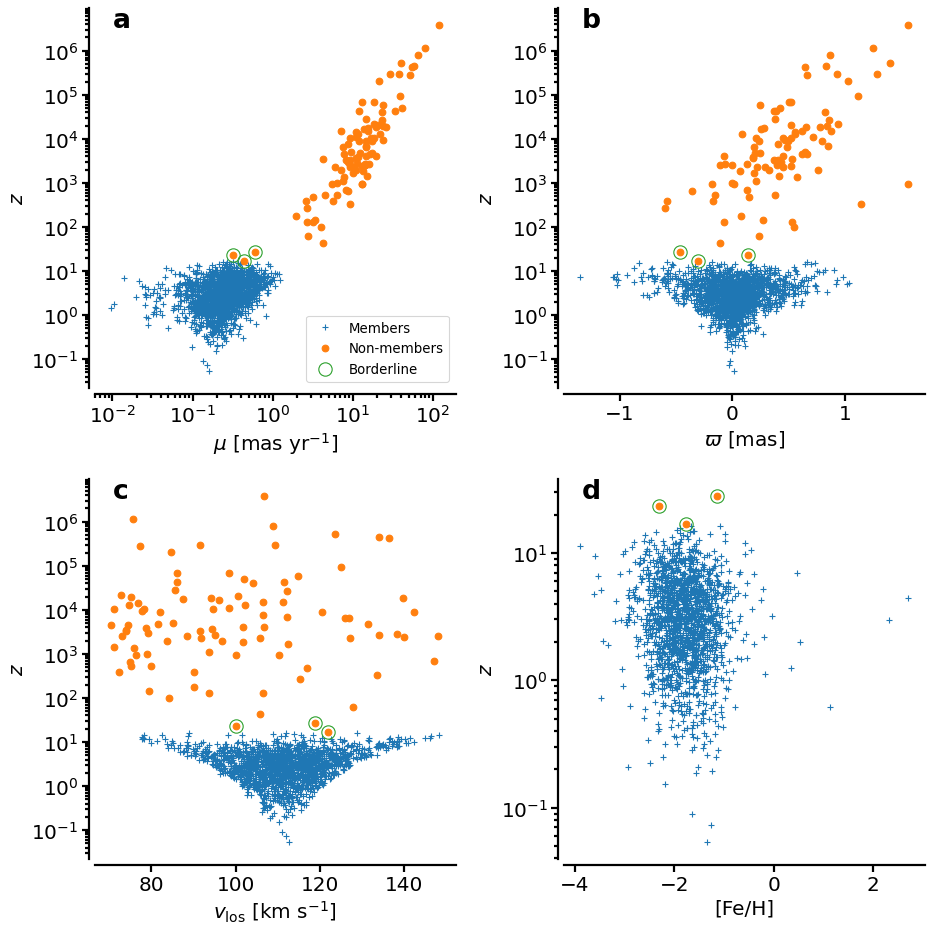

In [21]:
fig, axfeh = plt.subplots(2, 2, figsize=(12,12), tight_layout=True)
for ax in axfeh.flatten():
    apply_tufte(ax)

axfeh[0][0].loglog(scl_flames['pm'][flmems], scl_flames['zscore'][flmems], '+', label="Members")
axfeh[0][0].loglog(scl_flames['pm'][flnonmems], scl_flames['zscore'][flnonmems], 'o', label="Non-members")
axfeh[0][0].loglog(scl_flames['pm'][flnonmems_borderline], scl_flames['zscore'][flnonmems_borderline], 'o', mfc='none', ms=12, lw=3, label="Borderline")
axfeh[0][0].set_xlabel(r"$\mu$ [mas yr$^{-1}$]")
axfeh[0][0].set_ylabel(r"$z$")
axfeh[0][0].legend(fontsize=12, loc='lower right')
axfeh[0][0].text(0.05, 0.95, 'a', transform=axfeh[0][0].transAxes, fontsize=24, weight='bold')

axfeh[0][1].semilogy(scl_flames['parallax'][flmems], scl_flames['zscore'][flmems], '+', label="Members")
axfeh[0][1].semilogy(scl_flames['parallax'][flnonmems], scl_flames['zscore'][flnonmems], 'o', label="Non-members")
axfeh[0][1].semilogy(scl_flames['parallax'][flnonmems_borderline], scl_flames['zscore'][flnonmems_borderline], 'o', mfc='none', ms=12, lw=3)
axfeh[0][1].set_xlabel(r"$\varpi$ [mas]")
axfeh[0][1].set_ylabel(r"$z$")
axfeh[0][1].text(0.05, 0.95, 'b', transform=axfeh[0][1].transAxes, fontsize=24, weight='bold')
#axfeh[0][1].legend(fontsize=12)

axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flmems]]['aveVel'], scl_flames['zscore'][flmems], '+', label="Members")
axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems]]['aveVel'], scl_flames['zscore'][flnonmems], 'o', label="Non-members")
axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems_borderline]]['aveVel'], scl_flames['zscore'][flnonmems_borderline], 
                     'o', mfc='none', ms=12, lw=3)
axfeh[1][0].set_xlabel(r'$v_\mathrm{los}$ [km s$^{-1}]$')
axfeh[1][0].set_ylabel(r"$z$")
axfeh[1][0].text(0.05, 0.95, 'c', transform=axfeh[1][0].transAxes, fontsize=24, weight='bold')
#axfeh[1][0].legend(fontsize=12)

axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flmems]]['aveFeH'], scl_flames['zscore'][flmems], '+', label="Members")
axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems]]['aveFeH'], scl_flames['zscore'][flnonmems], 'o', label="Non-members")
axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems_borderline]]['aveFeH'], scl_flames['zscore'][flnonmems_borderline], 
                     'o', mfc='none', ms=12, lw=3)
axfeh[1][1].set_xlabel("[Fe/H]")
axfeh[1][1].set_ylabel(r"$z$")
axfeh[1][1].text(0.05, 0.95, 'd', transform=axfeh[1][1].transAxes, fontsize=24, weight='bold')
#axfeh[1][1].legend(fontsize=12)

plt.savefig("img/flames-membership-properties.pdf")

plt.show()

### FLAMES sources with reliable [Fe/H]

Number of FLAMES members with reliable [Fe/H]: 1339


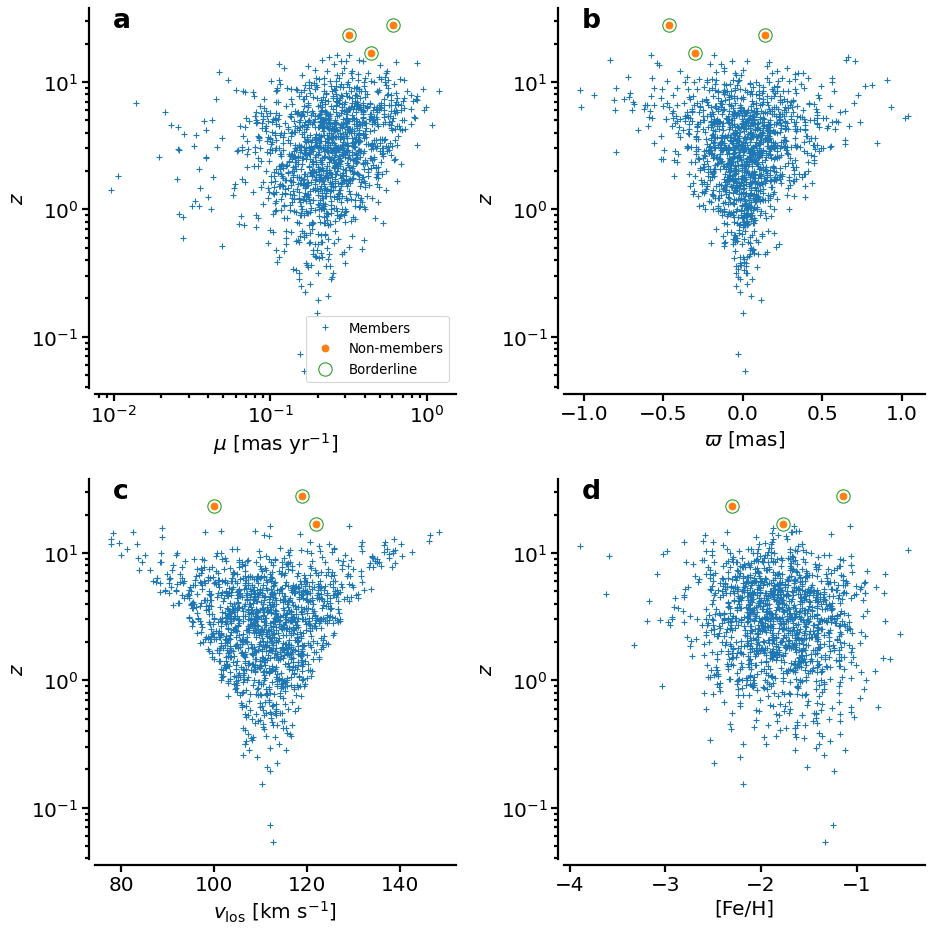

In [22]:
relfeh = (scl_flames['reliable_feh']==0)
print(f"Number of FLAMES members with reliable [Fe/H]: {scl_flames['ra'][flmems & relfeh].size}")

fig, axfeh = plt.subplots(2, 2, figsize=(12,12), tight_layout=True)
for ax in axfeh.flatten():
    apply_tufte(ax)

axfeh[0][0].loglog(scl_flames['pm'][flmems & relfeh], scl_flames['zscore'][flmems & relfeh], '+', label="Members")
axfeh[0][0].loglog(scl_flames['pm'][flnonmems & relfeh], scl_flames['zscore'][flnonmems & relfeh], 'o', label="Non-members")
axfeh[0][0].loglog(scl_flames['pm'][flnonmems_borderline & relfeh], scl_flames['zscore'][flnonmems_borderline & relfeh],
                   'o', mfc='none', ms=12, lw=3, label="Borderline")
axfeh[0][0].set_xlabel(r"$\mu$ [mas yr$^{-1}$]")
axfeh[0][0].set_ylabel(r"$z$")
axfeh[0][0].legend(fontsize=12, loc='lower right')
axfeh[0][0].text(0.05, 0.95, 'a', transform=axfeh[0][0].transAxes, fontsize=24, weight='bold')

axfeh[0][1].semilogy(scl_flames['parallax'][flmems & relfeh], scl_flames['zscore'][flmems & relfeh], '+', label="Members")
axfeh[0][1].semilogy(scl_flames['parallax'][flnonmems & relfeh], scl_flames['zscore'][flnonmems & relfeh], 'o', label="Non-members")
axfeh[0][1].semilogy(scl_flames['parallax'][flnonmems_borderline & relfeh], scl_flames['zscore'][flnonmems_borderline & relfeh], 'o', mfc='none', ms=12, lw=3)
axfeh[0][1].set_xlabel(r"$\varpi$ [mas]")
axfeh[0][1].set_ylabel(r"$z$")
axfeh[0][1].text(0.05, 0.95, 'b', transform=axfeh[0][1].transAxes, fontsize=24, weight='bold')
#axfeh[0][1].legend(fontsize=12)

axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flmems & relfeh]]['aveVel'], scl_flames['zscore'][flmems & relfeh], '+', label="Members")
axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems & relfeh]]['aveVel'], scl_flames['zscore'][flnonmems & relfeh], 'o', label="Non-members")
axfeh[1][0].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems_borderline & relfeh]]['aveVel'], scl_flames['zscore'][flnonmems_borderline & relfeh], 
                     'o', mfc='none', ms=12, lw=3)
axfeh[1][0].set_xlabel(r'$v_\mathrm{los}$ [km s$^{-1}]$')
axfeh[1][0].set_ylabel(r"$z$")
axfeh[1][0].text(0.05, 0.95, 'c', transform=axfeh[1][0].transAxes, fontsize=24, weight='bold')
#axfeh[1][0].legend(fontsize=12)

axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flmems & relfeh]]['aveFeH'], scl_flames['zscore'][flmems & relfeh], '+', label="Members")
axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems & relfeh]]['aveFeH'], scl_flames['zscore'][flnonmems & relfeh], 'o', label="Non-members")
axfeh[1][1].semilogy(scl_flames_et.loc[scl_flames['source_id'][flnonmems_borderline & relfeh]]['aveFeH'], scl_flames['zscore'][flnonmems_borderline & relfeh], 
                     'o', mfc='none', ms=12, lw=3)
axfeh[1][1].set_xlabel("[Fe/H]")
axfeh[1][1].set_ylabel(r"$z$")
axfeh[1][1].text(0.05, 0.95, 'd', transform=axfeh[1][1].transAxes, fontsize=24, weight='bold')
#axfeh[1][1].legend(fontsize=12)

plt.savefig("img/flames-membership-properties_reliable_feh.pdf")

plt.show()

### FLAMES sample in the CMD and on the sky

#### All FLAMES sources

/tmp/ipykernel_10979/2735246510.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  S1 = cm.get_cmap("Set1").colors[0]


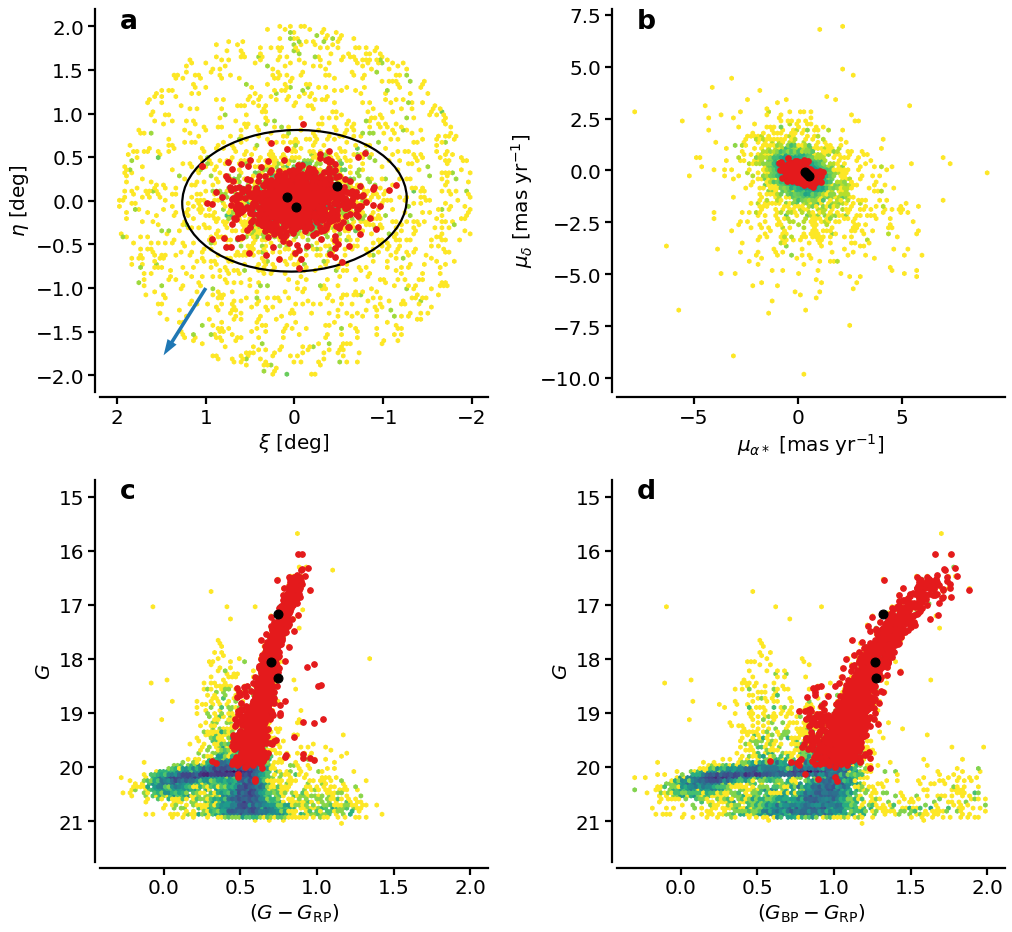

In [23]:
fig = plt.figure(figsize=(13,12), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axflmems = []
for i in range(2):
    axflmems.append([])
    for j in range(2):
        ax = fig.add_subplot(gs[i,j])
        apply_tufte(ax)
        axflmems[i].append(ax)
        
tidalC = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=2, ec='k')
pmarrow = Arrow(1,  -1, 5*pmra_scl_new, 5*pmdec_scl_new, width=0.2)
#pmsamples = multivariate_normal.rvs([pmra_scl_new, pmdec_scl_new], cov=covpm_scl_new, size=50)

S1 = cm.get_cmap("Set1").colors[0]

hb = axflmems[0][0].hexbin(scl['xi'][mems], scl['eta'][mems], mincnt=0, bins='log', cmap='viridis_r')
axflmems[0][0].plot(scl_flames['xi'][flmems], scl_flames['eta'][flmems], 'o', c=S1, ms=5, alpha=1)
axflmems[0][0].plot(scl_flames['xi'][flnonmems_borderline], scl_flames['eta'][flnonmems_borderline], 'o', c='k', ms=8, alpha=1)
#axflmems[0][0].plot(scl_flames['xi'][flnonmems], scl_flames['eta'][flnonmems], 'o', color='C6', label=rf"flames $\chi^2_{{4}}\geq{zscorelim_fl:.1f}$")
axflmems[0][0].add_patch(tidalC)
#for pmsample in pmsamples:
#    axflmems[0][0].add_patch(Arrow(1,  -1, 5*pmsample[0], 5*pmsample[1], width=0.1, alpha=0.1, fc="k", ec="k"))
axflmems[0][0].add_patch(pmarrow)
axflmems[0][0].set_xlabel(r'$\xi$ [deg]')
axflmems[0][0].set_ylabel(r'$\eta$ [deg]')
axflmems[0][0].invert_xaxis()
axflmems[0][0].text(0.05, 0.95, 'a', transform=axflmems[0][0].transAxes, fontsize=24, weight='bold')

hb = axflmems[0][1].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, bins='log', cmap="viridis_r")
axflmems[0][1].plot(scl_flames['pmra'][flmems], scl_flames['pmdec'][flmems], 'o', c=S1, ms=5, alpha=1)
axflmems[0][1].plot(scl_flames['pmra'][flnonmems_borderline], scl_flames['pmdec'][flnonmems_borderline], 'o', c='k', ms=8, alpha=1)
axflmems[0][1].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
axflmems[0][1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')
axflmems[0][1].text(0.05, 0.95, 'b', transform=axflmems[0][1].transAxes, fontsize=24, weight='bold')

hb = axflmems[1][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="viridis_r")
axflmems[1][0].plot(scl_flames['g_rp'][flmems], scl_flames['phot_g_mean_mag'][flmems], 'o', c=S1, ms=5, alpha=1)
axflmems[1][0].plot(scl_flames['g_rp'][flnonmems_borderline], scl_flames['phot_g_mean_mag'][flnonmems_borderline], 'o', c='k', ms=8, alpha=1)
axflmems[1][0].set_xlabel(r'$(G-G_\mathrm{RP})$')
axflmems[1][0].set_ylabel(r'$G$')
axflmems[1][0].invert_yaxis()
axflmems[1][0].text(0.05, 0.95, 'c', transform=axflmems[1][0].transAxes, fontsize=24, weight='bold')

hb = axflmems[1][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="viridis_r")
axflmems[1][1].plot(scl_flames['bp_rp'][flmems], scl_flames['phot_g_mean_mag'][flmems], 'o', c=S1, ms=5, alpha=1)
axflmems[1][1].plot(scl_flames['bp_rp'][flnonmems_borderline], scl_flames['phot_g_mean_mag'][flnonmems_borderline], 'o', c='k', ms=8, alpha=1)
axflmems[1][1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axflmems[1][1].set_ylabel(r'$G$')
axflmems[1][1].invert_yaxis()
axflmems[1][1].text(0.05, 0.95, 'd', transform=axflmems[1][1].transAxes, fontsize=24, weight='bold')

plt.savefig("img/flames-members-skypmcmd.pdf")

plt.show()

#### FLAMES members with reliable [Fe/H]

/tmp/ipykernel_10979/601591954.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  S1 = cm.get_cmap("Set1").colors[0]


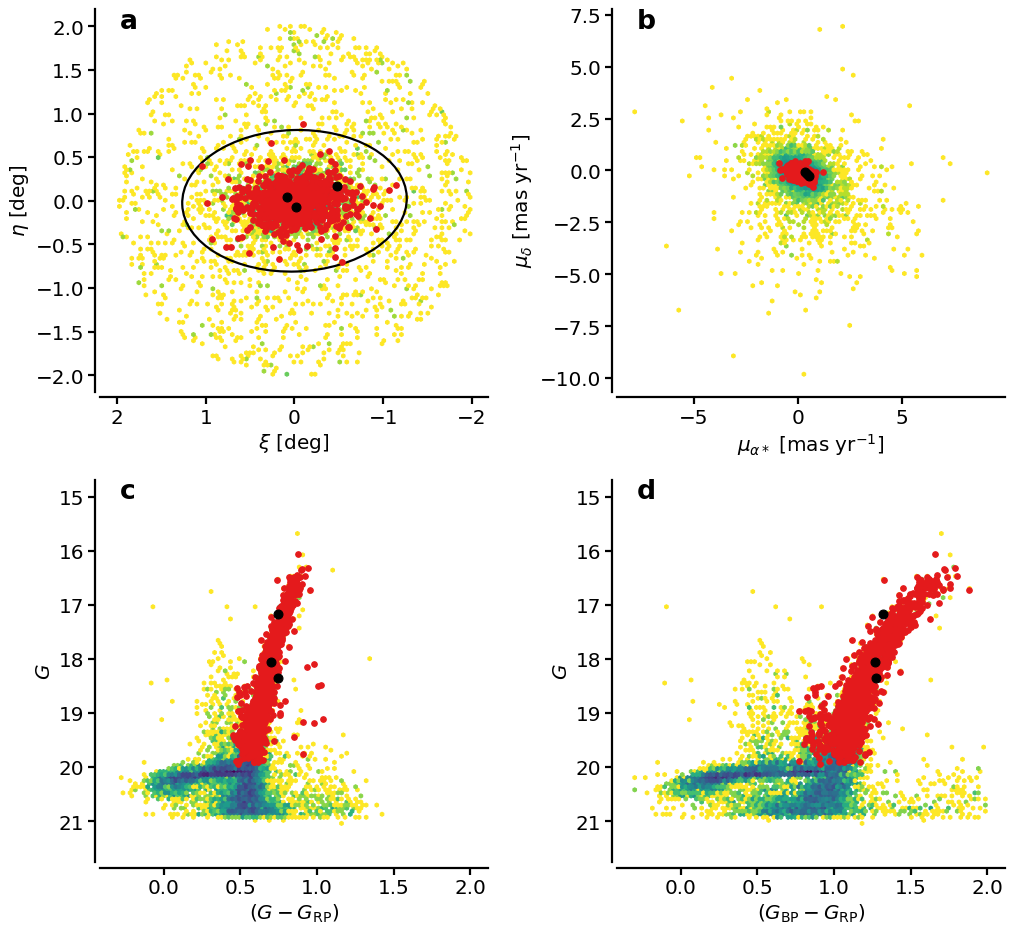

In [24]:
fig = plt.figure(figsize=(13,12), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axflmems = []
for i in range(2):
    axflmems.append([])
    for j in range(2):
        ax = fig.add_subplot(gs[i,j])
        apply_tufte(ax)
        axflmems[i].append(ax)
        
tidalC = Ellipse((0,0), width=2*rellmax, height=2*rellmax*(1-ellipticity_scl), angle=90-pa_scl, fill=False, lw=2, ec='k')

S1 = cm.get_cmap("Set1").colors[0]

hb = axflmems[0][0].hexbin(scl['xi'][mems], scl['eta'][mems], mincnt=0, bins='log', cmap='viridis_r')
axflmems[0][0].plot(scl_flames['xi'][flmems & relfeh], scl_flames['eta'][flmems & relfeh], 'o', c=S1, ms=5, alpha=1)
axflmems[0][0].plot(scl_flames['xi'][flnonmems_borderline & relfeh], scl_flames['eta'][flnonmems_borderline & relfeh], 'o', c='k', ms=8, alpha=1)
axflmems[0][0].add_patch(tidalC)
axflmems[0][0].set_xlabel(r'$\xi$ [deg]')
axflmems[0][0].set_ylabel(r'$\eta$ [deg]')
axflmems[0][0].invert_xaxis()
axflmems[0][0].text(0.05, 0.95, 'a', transform=axflmems[0][0].transAxes, fontsize=24, weight='bold')

hb = axflmems[0][1].hexbin(scl['pmra'][mems], scl['pmdec'][mems], mincnt=0, bins='log', cmap="viridis_r")
axflmems[0][1].plot(scl_flames['pmra'][flmems & relfeh], scl_flames['pmdec'][flmems & relfeh], 'o', c=S1, ms=5, alpha=1)
axflmems[0][1].plot(scl_flames['pmra'][flnonmems_borderline & relfeh], scl_flames['pmdec'][flnonmems_borderline & relfeh], 'o', c='k', ms=8, alpha=1)
axflmems[0][1].set_xlabel(r'$\mu_{\alpha*}$ [mas yr$^{-1}$]')
axflmems[0][1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')
axflmems[0][1].text(0.05, 0.95, 'b', transform=axflmems[0][1].transAxes, fontsize=24, weight='bold')

hb = axflmems[1][0].hexbin(scl['g_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="viridis_r")
axflmems[1][0].plot(scl_flames['g_rp'][flmems & relfeh], scl_flames['phot_g_mean_mag'][flmems & relfeh], 'o', c=S1, ms=5, alpha=1)
axflmems[1][0].plot(scl_flames['g_rp'][flnonmems_borderline & relfeh], scl_flames['phot_g_mean_mag'][flnonmems_borderline & relfeh], 'o', c='k', ms=8, alpha=1)
axflmems[1][0].set_xlabel(r'$(G-G_\mathrm{RP})$')
axflmems[1][0].set_ylabel(r'$G$')
axflmems[1][0].invert_yaxis()
axflmems[1][0].text(0.05, 0.95, 'c', transform=axflmems[1][0].transAxes, fontsize=24, weight='bold')

hb = axflmems[1][1].hexbin(scl['bp_rp'][mems], scl['phot_g_mean_mag'][mems], mincnt=0, bins='log', extent=extnt, cmap="viridis_r")
axflmems[1][1].plot(scl_flames['bp_rp'][flmems & relfeh], scl_flames['phot_g_mean_mag'][flmems & relfeh], 'o', c=S1, ms=5, alpha=1)
axflmems[1][1].plot(scl_flames['bp_rp'][flnonmems_borderline & relfeh], scl_flames['phot_g_mean_mag'][flnonmems_borderline & relfeh], 'o', c='k', ms=8, alpha=1)
axflmems[1][1].set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})$')
axflmems[1][1].set_ylabel(r'$G$')
axflmems[1][1].invert_yaxis()
axflmems[1][1].text(0.05, 0.95, 'd', transform=axflmems[1][1].transAxes, fontsize=24, weight='bold')

plt.savefig("img/flames-members-skypmcmd-reliable-feh.pdf")

plt.show()

## Write out the files with the membership lists

In [25]:
scl['pm_plx_membership']=mems
scl['flames_membership']=scl['ra']<-10 # make all False to start with
scl['flames_nonmembership']=scl['ra']<-10 # make all False to start with
scl['flames_borderline']=scl['ra']<-10 # make all False to start with

tindcs = scl.loc_indices[scl_flames_et['GaiaDR3Id']]
for tin, i in zip(tindcs, range(flmems.size)):
    scl[tin]['flames_membership'] = flmems[i]
    scl[tin]['flames_nonmembership'] = flnonmems[i]
    scl[tin]['flames_borderline'] = flnonmems_borderline[i]

allmems = scl['pm_plx_membership'] | scl['flames_membership']

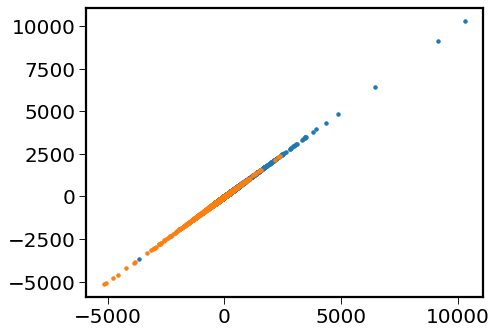

In [26]:
ra_j2000, dec_j2000 = ep.propagate_pos(np.deg2rad(scl['ra']), np.deg2rad(scl['dec']), scl['parallax'], scl['pmra'], scl['pmdec'], 0.0, 2016.0, 2000.0)

rad2mas = 3600*180*1000/np.pi
plt.plot((np.deg2rad(scl['ra'])-ra_j2000)*np.cos(np.deg2rad(scl['dec']))*rad2mas, scl['pmra']*16, '.')
plt.plot((np.deg2rad(scl['dec'])-dec_j2000)*rad2mas, scl['pmdec']*16, '.')
plt.show()

In [27]:
scl_for_et_all = scl['source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                     'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'zscore'][allmems]
scl_for_et_all['ra_j2000']=np.rad2deg(ra_j2000[allmems])*u.deg
scl_for_et_all['dec_j2000']=np.rad2deg(dec_j2000[allmems])*u.deg
scl_for_et_all['gmagerr'] = 2.5/(np.log(10)*scl['phot_g_mean_flux_over_error'][allmems])
scl_for_et_all['bpmagerr'] = 2.5/(np.log(10)*scl['phot_bp_mean_flux_over_error'][allmems])
scl_for_et_all['rpmagerr'] = 2.5/(np.log(10)*scl['phot_rp_mean_flux_over_error'][allmems])

scl_for_et_gaiaonly = scl['source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                     'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'zscore'][mems]
scl_for_et_gaiaonly['ra_j2000']=np.rad2deg(ra_j2000[mems])*u.deg
scl_for_et_gaiaonly['dec_j2000']=np.rad2deg(dec_j2000[mems])*u.deg
scl_for_et_gaiaonly['gmagerr'] = 2.5/(np.log(10)*scl['phot_g_mean_flux_over_error'][mems])
scl_for_et_gaiaonly['bpmagerr'] = 2.5/(np.log(10)*scl['phot_bp_mean_flux_over_error'][mems])
scl_for_et_gaiaonly['rpmagerr'] = 2.5/(np.log(10)*scl['phot_rp_mean_flux_over_error'][mems])

scl_for_et_flames = scl['source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                        'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'zscore'][scl['flames_membership']]
scl_for_et_flames['ra_j2000']=np.rad2deg(ra_j2000[scl['flames_membership']])*u.deg
scl_for_et_flames['dec_j2000']=np.rad2deg(dec_j2000[scl['flames_membership']])*u.deg
scl_for_et_flames['gmagerr'] = 2.5/(np.log(10)*scl['phot_g_mean_flux_over_error'][scl['flames_membership']])
scl_for_et_flames['bpmagerr'] = 2.5/(np.log(10)*scl['phot_bp_mean_flux_over_error'][scl['flames_membership']])
scl_for_et_flames['rpmagerr'] = 2.5/(np.log(10)*scl['phot_rp_mean_flux_over_error'][scl['flames_membership']])

select = scl['flames_nonmembership'] & ~scl['flames_borderline']
scl_for_et_flames_nonmem = scl['source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                        'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'zscore'][select]
scl_for_et_flames_nonmem['ra_j2000']=np.rad2deg(ra_j2000[select])*u.deg
scl_for_et_flames_nonmem['dec_j2000']=np.rad2deg(dec_j2000[select])*u.deg
scl_for_et_flames_nonmem['gmagerr'] = 2.5/(np.log(10)*scl['phot_g_mean_flux_over_error'][select])
scl_for_et_flames_nonmem['bpmagerr'] = 2.5/(np.log(10)*scl['phot_bp_mean_flux_over_error'][select])
scl_for_et_flames_nonmem['rpmagerr'] = 2.5/(np.log(10)*scl['phot_rp_mean_flux_over_error'][select])

select = scl['flames_borderline']
scl_for_et_flames_border = scl['source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                        'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'zscore'][select]
scl_for_et_flames_border['ra_j2000']=np.rad2deg(ra_j2000[select])*u.deg
scl_for_et_flames_border['dec_j2000']=np.rad2deg(dec_j2000[select])*u.deg
scl_for_et_flames_border['gmagerr'] = 2.5/(np.log(10)*scl['phot_g_mean_flux_over_error'][select])
scl_for_et_flames_border['bpmagerr'] = 2.5/(np.log(10)*scl['phot_bp_mean_flux_over_error'][select])
scl_for_et_flames_border['rpmagerr'] = 2.5/(np.log(10)*scl['phot_rp_mean_flux_over_error'][select])

scl_for_et_all.write('memdata/sculptor_members_et_all.ascii', format="ascii", overwrite=True)
scl_for_et_gaiaonly.write('memdata/sculptor_members_et_gaiaonly.ascii', format="ascii", overwrite=True)
scl_for_et_flames.write('memdata/sculptor_members_et_flames.ascii', format="ascii", overwrite=True)
scl_for_et_flames_nonmem.write('memdata/sculptor_nonmembers_et_flames.ascii', format="ascii", overwrite=True)
scl_for_et_flames_border.write('memdata/sculptor_borderline_et_flames.ascii', format="ascii", overwrite=True)

In [28]:
scl.write("memdata/Sculptor-all-withz.fits", format="fits", overwrite=True)
scl[mems].write("memdata/Sculptor-pmplx-members.fits", format="fits", overwrite=True)
#scl_flames_et.loc[scl_flames['source_id'][flmems]].write("FLAMES-members.txt", format="ascii", overwrite=True)
#scl_flames_et.loc[scl_flames['source_id'][flnonmems]].write("FLAMES-non-members.txt", format="ascii", overwrite=True)